# Analyzing football players data (from FIFA 20)

## Summary

- [Data Cleaning](#1---Data-cleaning)
- [Data Analysis](#2---Data-analysis)
 - [High quality players (Overall rating >= 90)](#2.01---High-quality-players-(Overall-rating->=-90))
 - [Comparing players values and wages](#2.02---Comparing-players-values-and-wages)
 - [Top players by country](#2.03---Top-players-by-country)
 - [Top players by position](#2.04---Top-players-by-position)
 - [Top players by relative potential](#2.04---Top-players-by-relative-potential)
 - [Comparing clubs and national teams](#2.05---Comparing-clubs-and-national-teams)
 - [Choosing the right players for the national teams](#2.06---Choosing-the-right-players-for-the-national-teams)
 - [Looking for linear correlations between attributes](#2.07---Looking-for-linear-correlations-between-attributes)
 - [Wage statistics](#2.08---Wage-statistics)
 - [Best and worst attributes for each position](#2.09---Best-and-worst-attributes-for-each-position)
 - [Number of players by position](#2.10---Number-of-players-by-position)
 - [Right-footed vs Left-footed players](#2.11---Right-footed-vs-Left-footed-players)
 - [Height, Weight, and BMI of players](#2.12---Height,-Weight,-and-BMI-of-players)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
players_df = pd.read_csv('fifaindex_players.csv')
players_df.head()

,name,overall,potential,nationality,description,height,weight,preferred_foot,birth_date,age,...,curve,fk_acc,penalties,volleys,gk_positioning,gk_diving,gk_handling,gk_kicking,gk_reflexes,specialities_traits
0,Lionel Messi,94,94,Argentina,"Lionel Messi was born on June 24, 1987. He is ...",170 cm,72 kg,Left,"June 24, 1987",33,...,93,94,75,88,14,6,11,15,8,Dribbler/Distance Shooter/Crosser/FK Specialis...
1,Cristiano Ronaldo,93,93,Portugal,"Cristiano Ronaldo was born on Feb. 5, 1985. He...",187 cm,83 kg,Right,"Feb. 5, 1985",35,...,81,76,85,87,14,7,11,15,11,Dribbler/Distance Shooter/Acrobat/Clinical Fin...
2,Neymar Jr,92,92,Brazil,"Neymar Jr was born on Feb. 5, 1992. He is curr...",175 cm,68 kg,Right,"Feb. 5, 1992",28,...,88,89,92,87,15,9,9,15,11,Speedster/Dribbler/Playmaker/Crosser/FK Specia...
3,Virgil van Dijk,91,92,Netherlands,"Virgil van Dijk was born on July 8, 1991. He i...",193 cm,92 kg,Right,"July 8, 1991",29,...,60,70,62,45,11,13,10,13,11,Tackling/Tactician/Strength/Complete Defender/...
4,Jan Oblak,91,93,Slovenia,"Jan Oblak was born on Jan. 7, 1993. He is curr...",188 cm,87 kg,Right,"Jan. 7, 1993",27,...,13,14,11,13,90,87,92,78,89,Flair/Acrobatic Clearance


# 1 - Data cleaning

In [2]:
# Some players have team_club and team_nation values switched due to random differences in FIFA Index page layouts
# This code corrects this issue by using the fact that team_nation must be equal to the nationality of the player
condition = players_df['team_club']==players_df['nationality']
players_df.loc[condition,'team_club'] = players_df[condition]['team_nation']
players_df.loc[condition,'team_nation'] = players_df[condition]['nationality']

In [3]:
# In the scrapper, missing data was assigned to 0, but there are also empty string missing data.
players_df = players_df.replace([0,'0',' '],np.nan)

# Removing strings from numeric features and converting them into int (or float)
players_df['height'] = players_df['height'].apply(lambda x: x.strip(' cm')).astype(int)
players_df['weight'] = players_df['weight'].apply(lambda x: x.strip(' kg')).astype(int)
players_df['value'] = players_df['value'].apply(lambda x: x.strip('€').replace('.','') if (pd.notna(x)) else x).astype(float)
players_df['wage'] = players_df['wage'].apply(lambda x: x.strip('€').replace('.','') if (pd.notna(x)) else x).astype(float)

In [4]:
players_df.isna().sum()

name                       0
overall                    0
potential                  0
nationality                0
description                0
height                     0
weight                     0
preferred_foot             0
birth_date                 0
age                        0
preferred_positions        0
work_rate                  0
weak_foot                  0
skill_moves                0
value                    217
wage                     376
team_club                  1
team_nation            18499
ball_control               0
dribbling                  0
marking                    0
side_tackle                0
stand_tackle               0
aggression                 0
reactions                  0
att_position               0
interceptions              0
vision                     0
composure                  0
crossing                   0
short_pass                 0
long_pass                  0
acceleration               0
stamina                    0
strength      

To me, it is really weird that the scraper was not able to gather the wages of some players (with value assigned to them). Some of the players that have value but missing wage are displayed below. After inspecting their pages on FIFA Index website I was not able to see why this happened (See, for instance, [Morata](https://www.fifaindex.com/player/201153/morata/)), and I will just ignore that in this and future analysis (this happens only for 160 random players).

In [5]:
players_without_wage = players_df[players_df['wage'].isna()][['name','value','wage']]
players_without_wage[players_without_wage['value'].notna()].head(10)

,name,value,wage
191,Morata,31000000.0,NaN
376,Henrikh Mkhitaryan,17000000.0,NaN
382,Chris Smalling,15000000.0,NaN
391,Alexis Sánchez,17000000.0,NaN
453,Tiemoué Bakayoko,16500000.0,NaN
569,Dean Henderson,14500000.0,NaN
801,Mario Pašalić,13500000.0,NaN
811,Islam Slimani,9500000.0,NaN
817,Davide Zappacosta,10500000.0,NaN
871,Loris Karius,9500000.0,NaN


# 2 - Data analysis

# 2.01 - High quality players (Overall rating >= 90)

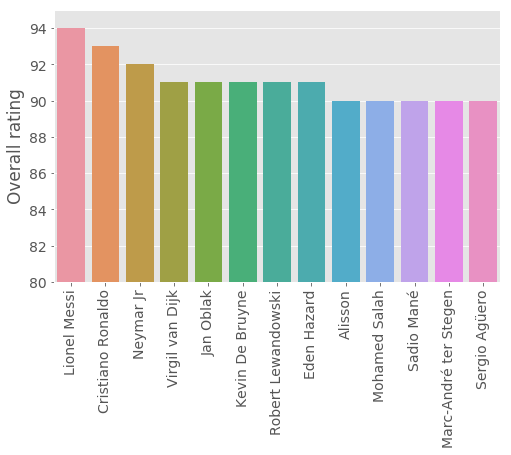

In [6]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(1,1,figsize=(8,5))
players = players_df[players_df['overall'] >= 90][['name','overall']]
plot = sns.barplot(x='name',y='overall',data=players,ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Overall rating')
ax.set_ylim(80,95)
plot.set_xticklabels(plot.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='center')
plt.show()

### FIFA knows that Messi > Cristiano Ronaldo!

# 2.02 - Comparing players values and wages

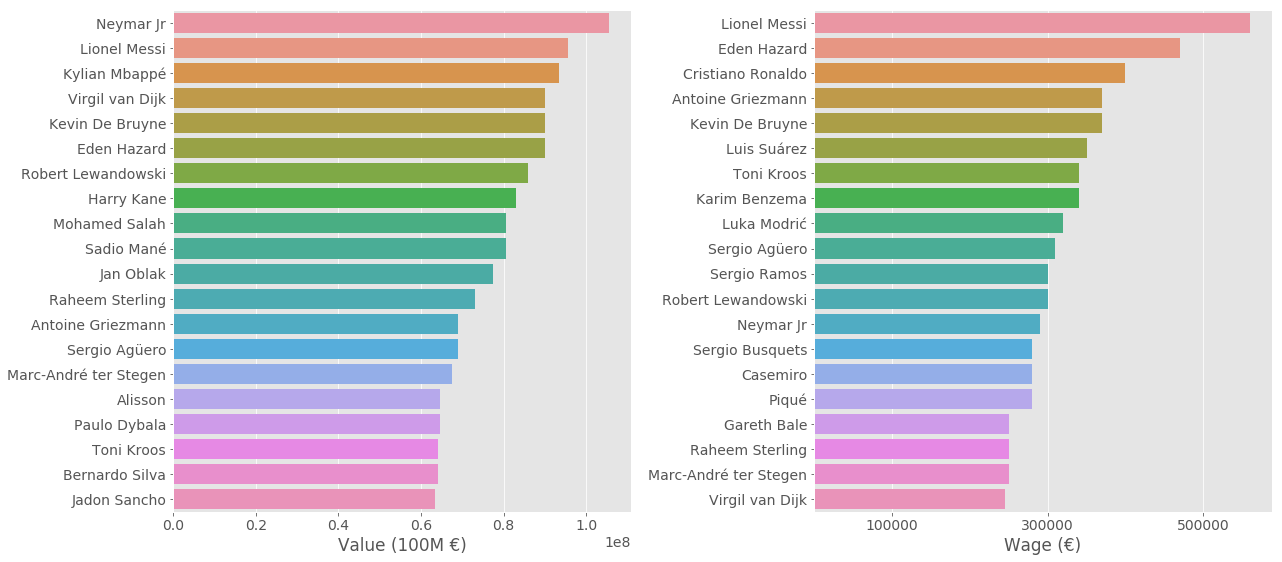

In [7]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(1,2,figsize=(18,8))
values = players_df.sort_values('value',ascending=False)[['name','value']][:20]
wages = players_df.sort_values('wage',ascending=False)[['name','wage']][:20]
sns.barplot(x='value',y='name',data=values,ax=ax[0])
sns.barplot(x='wage',y='name',data=wages,ax=ax[1])
ax[0].set_xlabel('Value (100M €)')
ax[0].set_ylabel('')
ax[1].set_xlabel('Wage (€)')
ax[1].set_ylabel('')
ax[1].set_xticks([100000,300000,500000])
fig.tight_layout(pad=1)
plt.show()

It is interesting to notice that some players (like Mbappé and van Dijk) do not have a sallary compatible with his value. The opposite also happens for some players. Cristiano Ronaldo for example has the 3rd highest wage but does not appear in the top 20 most valuable players. Luis Suarez is another example of that.

# 2.03 - Top players by country

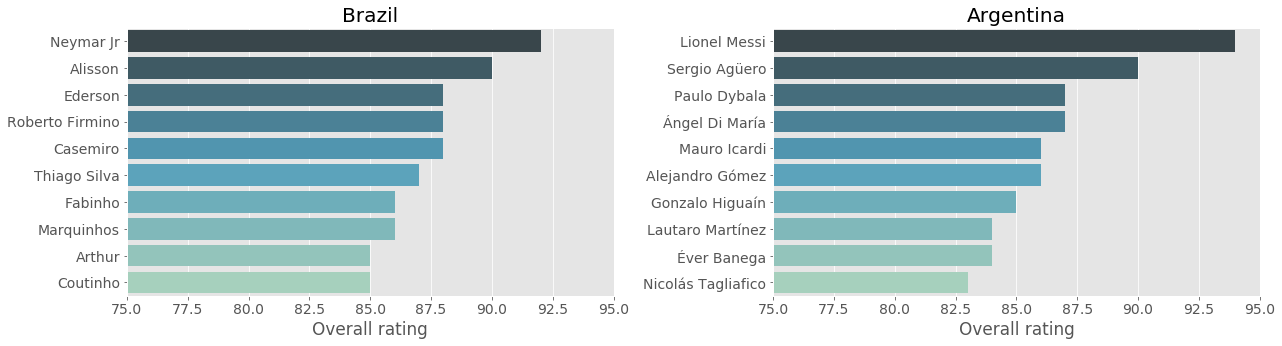

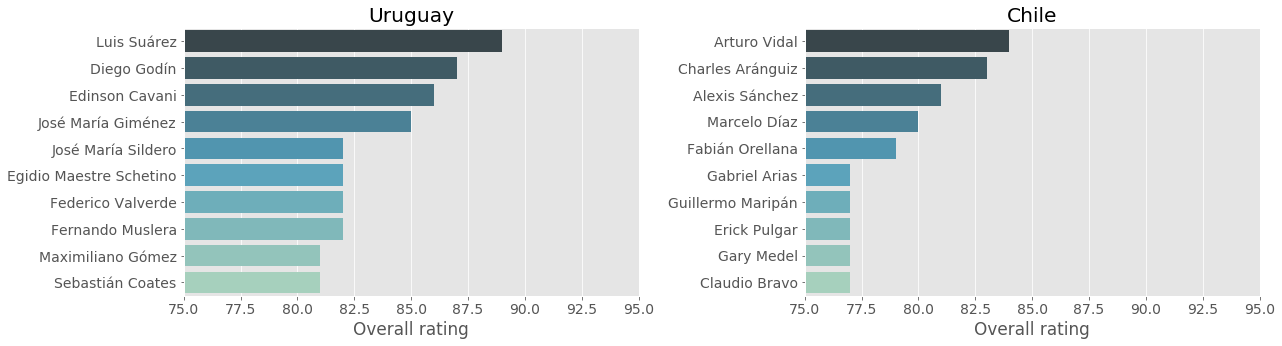

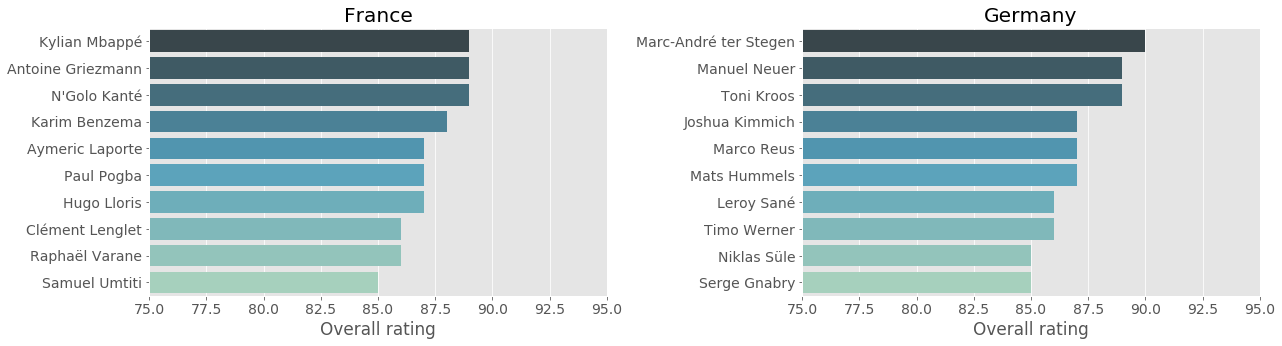

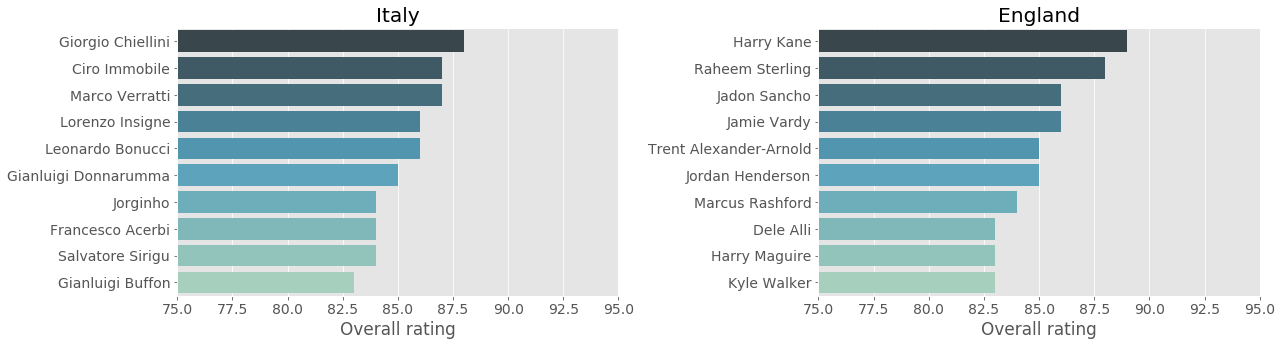

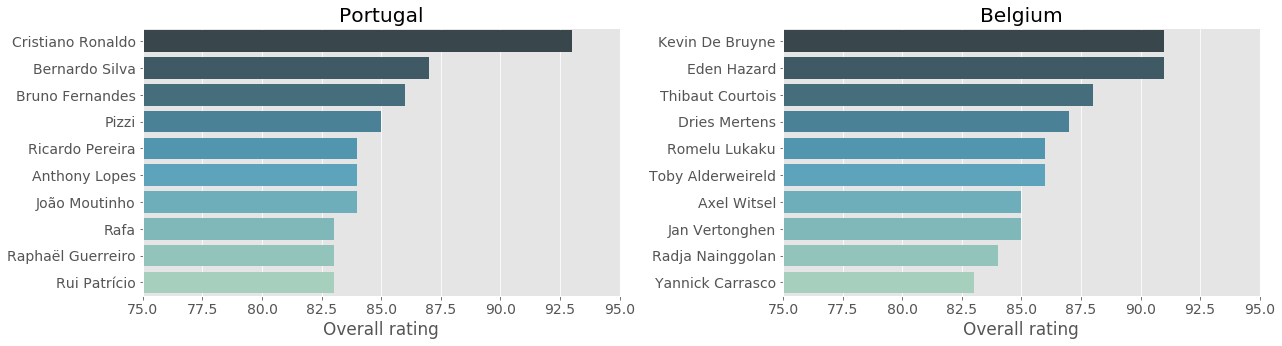

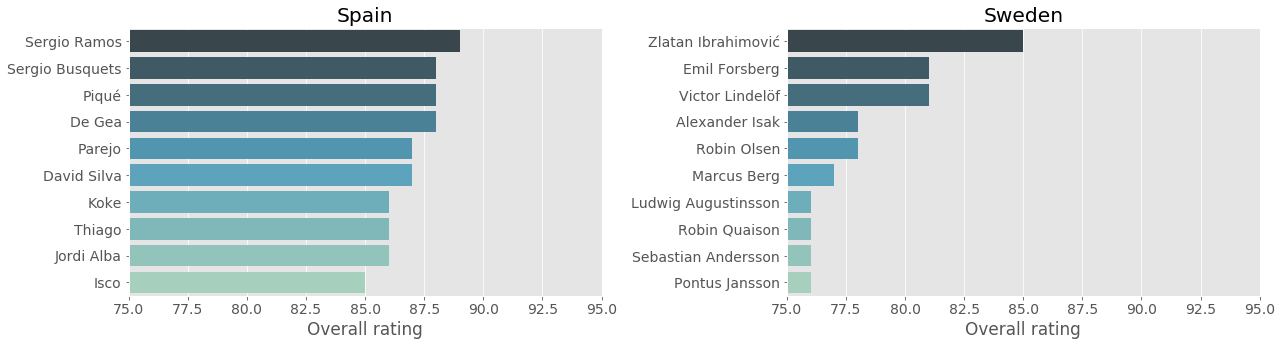

In [8]:
def plot_top_players_countries(country1,country2):
    fig,ax = plt.subplots(1,2,figsize=(18,5))
    players_c1 = players_df[players_df['nationality']== country1].sort_values('overall',ascending=False)[['name','overall']][:10]
    players_c2 = players_df[players_df['nationality']== country2].sort_values('overall',ascending=False)[['name','overall']][:10]
    sns.barplot(x='overall',y='name',data=players_c1,ax=ax[0],palette="GnBu_d")
    sns.barplot(x='overall',y='name',data=players_c2,ax=ax[1],palette="GnBu_d")
    ax[0].set_xlabel('Overall rating')
    ax[0].set_xlim(75,95)
    ax[0].set_ylabel('')
    ax[0].set_title(country1)
    ax[1].set_xlabel('Overall rating')
    ax[1].set_ylabel('')
    ax[1].set_xlim(75,95)
    ax[1].set_title(country2)
    fig.tight_layout(pad=1)
    plt.show()
    
countries = ['Brazil','Argentina','Uruguay','Chile','France','Germany','Italy','England','Portugal','Belgium','Spain','Sweden']


for i in range(int(len(countries)/2)):
    plot_top_players_countries(countries[2*i],countries[2*i + 1])

# 2.04 - Top players by position

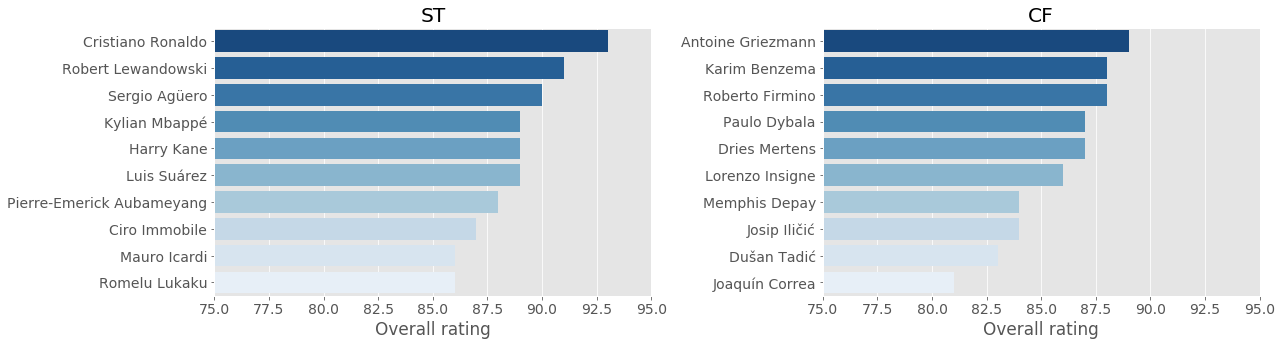

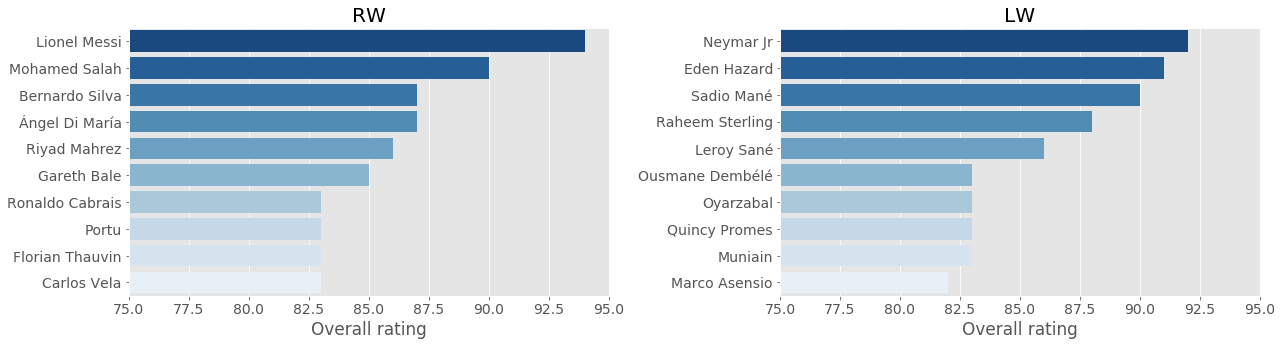

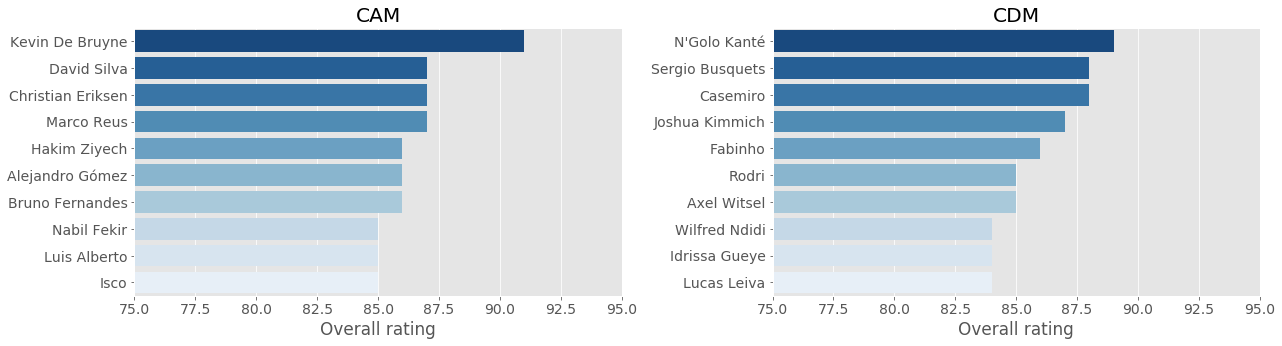

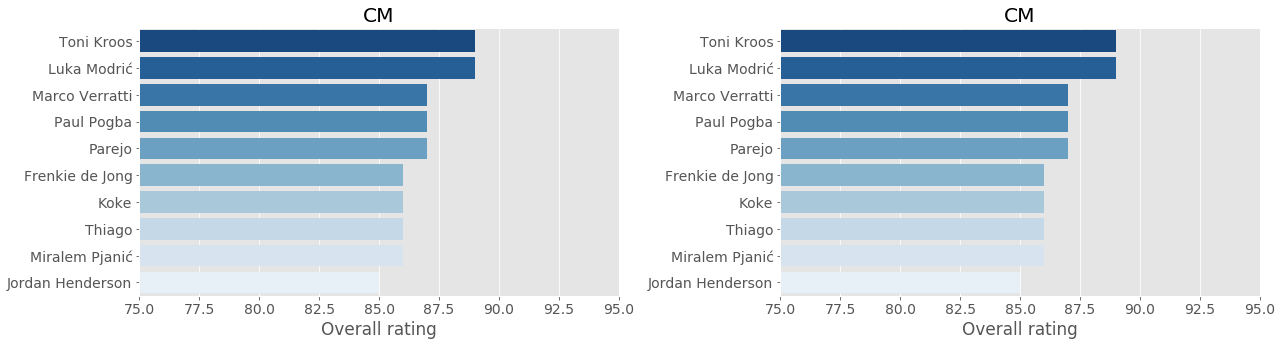

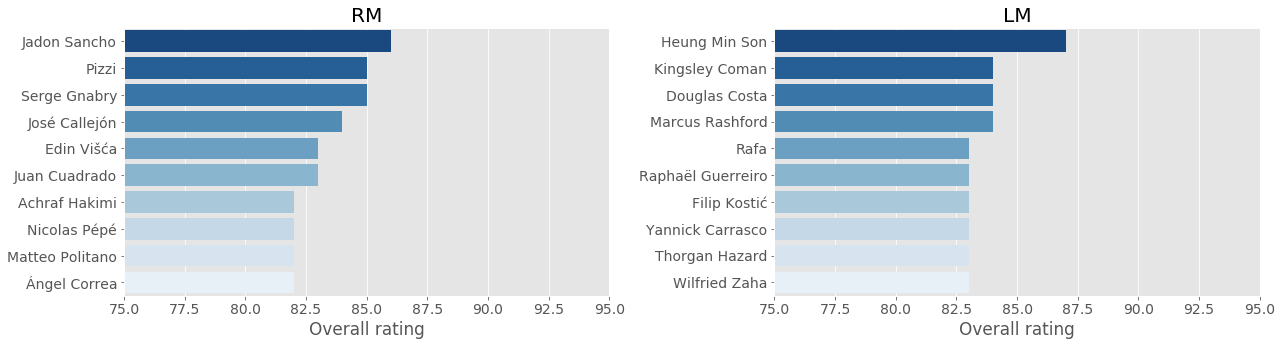

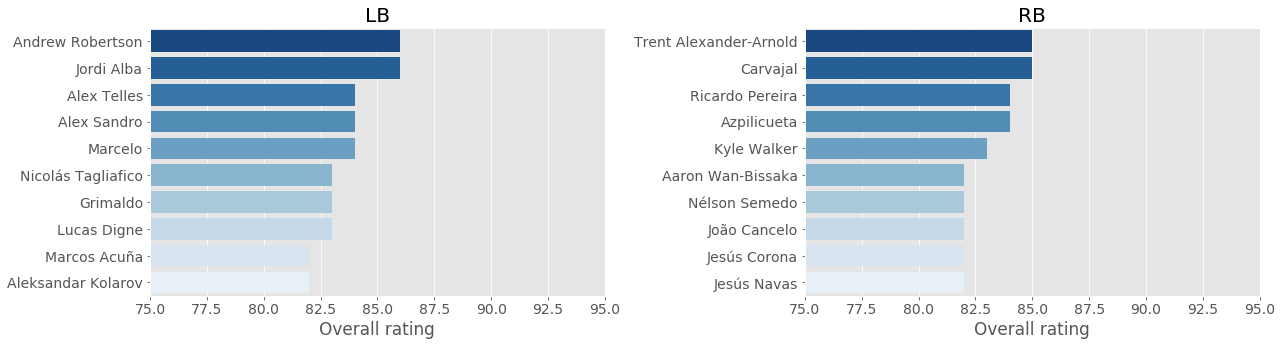

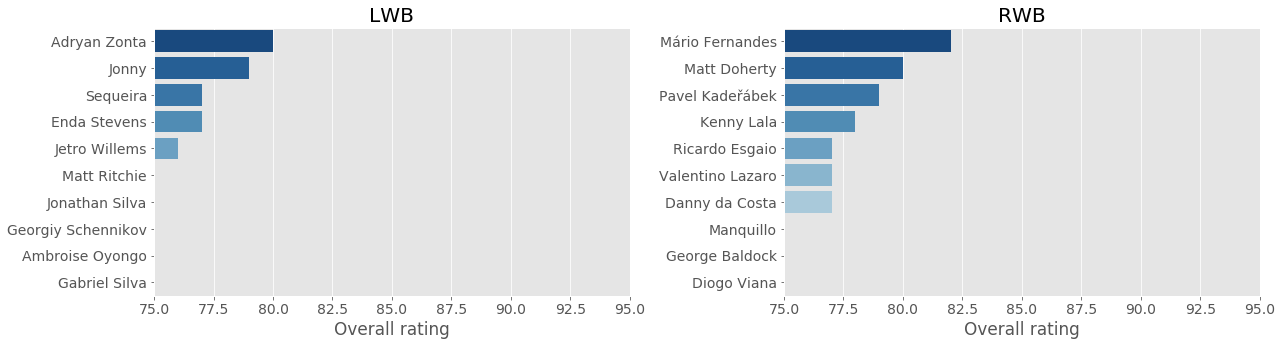

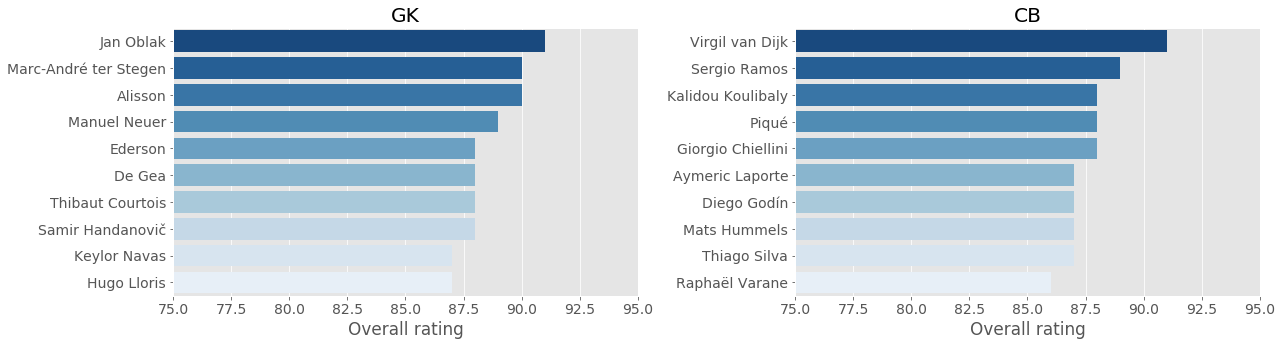

In [9]:
players_df['first_position'] = players_df['preferred_positions'].apply(lambda x: x.split('/')[0])

def plot_top_players_positions(position1,position2):
    fig,ax = plt.subplots(1,2,figsize=(18,5))
    players_p1 = players_df[players_df['first_position']== position1].sort_values('overall',ascending=False)[['name','overall']][:10]
    players_p2 = players_df[players_df['first_position']== position2].sort_values('overall',ascending=False)[['name','overall']][:10]
    sns.barplot(x='overall',y='name',data=players_p1,ax=ax[0],palette="Blues_r")
    sns.barplot(x='overall',y='name',data=players_p2,ax=ax[1],palette="Blues_r")
    ax[0].set_xlabel('Overall rating')
    ax[0].set_xlim(75,95)
    ax[0].set_ylabel('')
    ax[0].set_title(position1)
    ax[1].set_xlabel('Overall rating')
    ax[1].set_ylabel('')
    ax[1].set_xlim(75,95)
    ax[1].set_title(position2)
    fig.tight_layout(pad=1)
    plt.show()
    
positions = ['ST','CF','RW','LW','CAM','CDM','CM','CM','RM','LM','LB','RB','LWB','RWB','GK','CB']


for i in range(int(len(positions)/2)):
    plot_top_players_positions(positions[2*i],positions[2*i + 1])

# 2.04 - Top players by relative potential

In [10]:
# My definition of relative potential
players_df['relative_potential'] = players_df['potential'] - players_df['overall']
# (e.g., Neymar has potential = 94, but also overall = 94, hence, his relative potential will be 0)

promissing_players = players_df[players_df['overall']>70].sort_values('relative_potential',ascending=False)[['name','age','team_club','preferred_positions','overall','potential']]
promissing_players[:15]

,name,age,team_club,preferred_positions,overall,potential
3372,Reinier,18,Real Madrid,CF/CAM,72,90
2742,Ansu Fati,17,FC Barcelona,LW/RW,73,90
3380,Pedri,17,UD Las Palmas,LM/CAM,72,89
4246,Riqui Puig,21,FC Barcelona,CM,71,87
2146,Mason Greenwood,18,Manchester United,ST/RM,74,89
4207,Agustín Urzi,20,Club Atlético Banfield,LM/CM/RM,71,86
4242,Rafael Camacho,20,Sporting CP,RW,71,86
4221,Mohammed Kudus,20,FC Nordsjælland,CF/CM,71,86
3471,Takefusa Kubo,19,RCD Mallorca,RM/CM/CAM,72,87
4258,Hamed Junior Traorè,20,Sassuolo,CAM/CM,71,86


There are many promissing players in La Liga.

# 2.05 - Comparing clubs and national teams

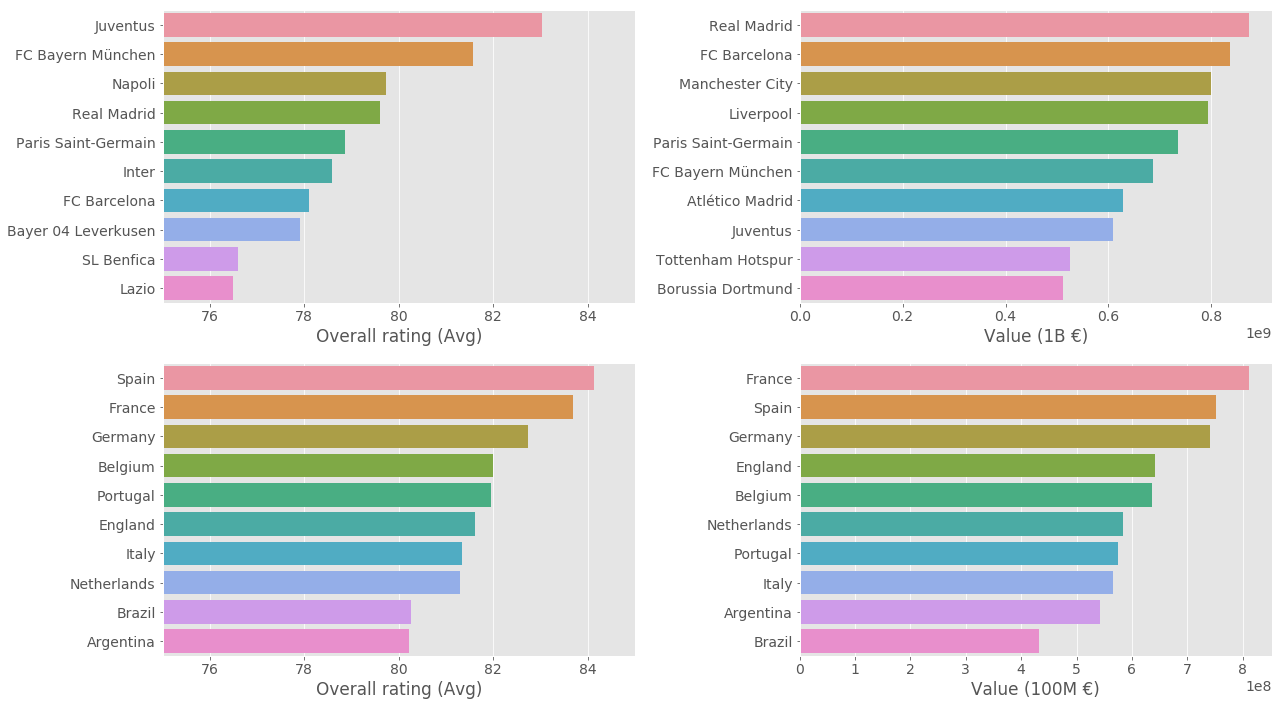

In [11]:
clubs_overall = players_df.groupby('team_club')['overall'].mean().sort_values(ascending=False)[:10]
clubs_value = players_df.groupby('team_club')['value'].sum().sort_values(ascending=False)[:10]
nations_overall = players_df.groupby('team_nation')['overall'].mean().sort_values(ascending=False)[:10]
nations_value = players_df.groupby('team_nation')['value'].sum().sort_values(ascending=False)[:10]

fig,ax = plt.subplots(2,2,figsize=(18,10))
sns.barplot(x=clubs_overall.values,y=clubs_overall.index,ax=ax[0,0])
sns.barplot(x=clubs_value.values,y=clubs_value.index,ax=ax[0,1])
sns.barplot(x=nations_overall.values,y=nations_overall.index,ax=ax[1,0])
sns.barplot(x=nations_value.values,y=nations_value.index,ax=ax[1,1])
ax[0,0].set_xlabel('Overall rating (Avg)')
ax[0,0].set_xlim(75,85)
ax[0,0].set_ylabel('')
ax[0,1].set_xlabel('Value (1B €)')
ax[0,1].set_ylabel('')
ax[1,0].set_xlabel('Overall rating (Avg)')
ax[1,0].set_xlim(75,85)
ax[1,0].set_ylabel('')
ax[1,1].set_xlabel('Value (100M €)')
ax[1,1].set_ylabel('')
fig.tight_layout(pad=1)
plt.show()

Spain and France seems to be the most promissing teams for the next years. Brazil is probably not too far behind, the problem with this data is that [FIFA 20 does not have the Brazilian national team licensed in the game](https://fifaforums.easports.com/en/discussion/492889/brazil-national-team).

## 2.05.1 - Most valuable players in the most valuable teams

In [12]:
def most_valuable_players(team,kind='club',number_players=10):
    team = players_df[players_df['team_'+kind] == team][['name','value']].set_index('name')
    team_top = team.sort_values('value',ascending=False)[:number_players]
    team_top.loc['Others'] = team.sort_values('value',ascending=False)[number_players:].sum()
    return team_top

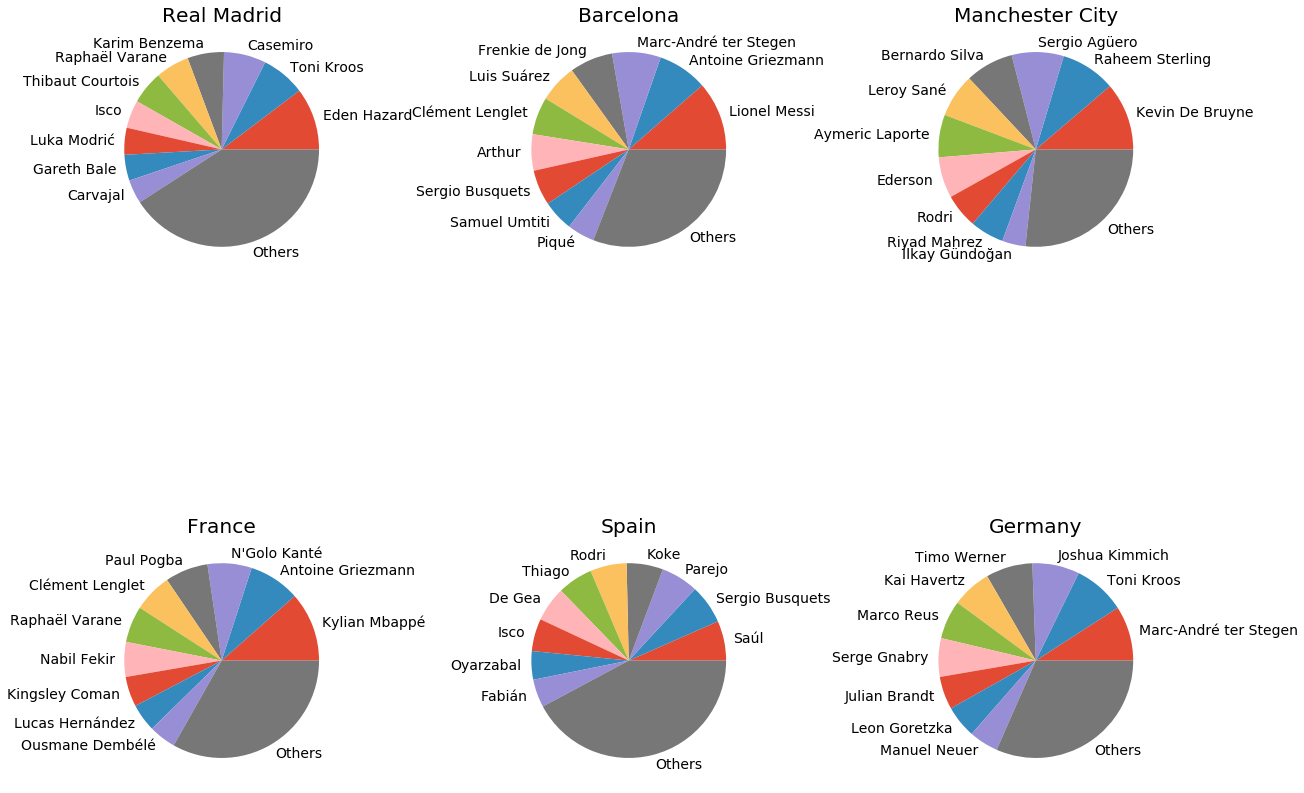

In [120]:
fig,ax = plt.subplots(2,3,figsize=(18,15))
most_valuable_players('Real Madrid').plot(kind='pie',y='value',ax=ax[0,0],legend=False)
most_valuable_players('FC Barcelona').plot(kind='pie',y='value',ax=ax[0,1],legend=False)
most_valuable_players('Manchester City').plot(kind='pie',y='value',ax=ax[0,2],legend=False)
most_valuable_players('France',kind='nation').plot(kind='pie',y='value',ax=ax[1,0],legend=False)
most_valuable_players('Spain',kind='nation').plot(kind='pie',y='value',ax=ax[1,1],legend=False)
most_valuable_players('Germany',kind='nation').plot(kind='pie',y='value',ax=ax[1,2],legend=False)
ax[0,0].set_ylabel('')
ax[0,0].set_title('Real Madrid')
ax[0,1].set_ylabel('')
ax[0,1].set_title('Barcelona')
ax[0,2].set_ylabel('')
ax[0,2].set_title('Manchester City')
ax[1,0].set_ylabel('')
ax[1,0].set_title('France')
ax[1,1].set_ylabel('')
ax[1,1].set_title('Spain')
ax[1,2].set_ylabel('')
ax[1,2].set_title('Germany')

fig.tight_layout(pad=0.5)
plt.show()

Some teams rely on their starting players and others not so much. Unlike Barcelona and Manchester City, Real Madrid has a bench that is not so less valuable than the top players of the team, and this makes the difference.

# 2.06 - Choosing the right players for the national teams

Have you ever gone crazy with your national team manager who seems to not be able to put the right players to play? If your answer is yes, you will like this section. Here I define a function that constructs the best possible team with the current football players of your country. Just specify how many players do you want for each position and you will have it. Of course this is not fair enough since it relies on FIFA 20 overall ratings of players, which is not what matters in real life. But yet, we can have a little bit of fun by looking at the resulting teams.

In [14]:
def national_team_constructor(nation,positions={'GK':1,'CB':2,'LB':1,'RB':1,'CDM':1,'CM':2,'LW':1,'RW':1,'ST':1}):
    players_nation = players_df[players_df['nationality']==nation][['name','first_position','preferred_positions','overall','value','team_club']]
    national_team = pd.DataFrame()
    
    # First try to fill all positions with players that have this as their first position
    for position in positions.keys():
        players_position = players_nation[players_nation['first_position'] == position].sort_values(['overall','value'],ascending=[False,False])[:positions[position]]
        national_team = pd.concat([national_team,players_position],ignore_index=True)
    
    # Then look for better options with players second/third preferred positions
    for player in national_team.iterrows():
        possible_players = players_nation[players_nation['preferred_positions'].str.contains(player[1]['first_position'])].sort_values(['overall','value'],ascending=[False,False])[:10]
        possible_player = possible_players[~possible_players['name'].isin(national_team['name'].tolist())].iloc[0]
        if possible_player['overall'] > player[1]['overall']:
            national_team.iloc[player[0]] = possible_player.tolist()
        # The value of the player was choosen as the resolution criteria if the overall is the same
        elif (possible_player['overall'] == player[1]['overall']) and (possible_player['value'] > player[1]['value']):
            national_team.iloc[player[0]] = possible_player.tolist()
            
    return national_team[['name','preferred_positions','overall','team_club']]
    

Below I just use this function to get the best possible first starting teams in a 4-3-3 formation. Let's see who they are.

## Brazil (4-3-3)

In [15]:
national_team_constructor('Brazil')

,name,preferred_positions,overall,team_club
0,Alisson,GK,90,Liverpool
1,Thiago Silva,CB,87,Paris Saint-Germain
2,Marquinhos,CB/CDM,86,Paris Saint-Germain
3,Alex Telles,LB,84,FC Porto
4,Éder Militão,CB/RB,81,Real Madrid
5,Casemiro,CDM,88,Real Madrid
6,Arthur,CM,85,FC Barcelona
7,Coutinho,CAM/LW/CM,85,FC Bayern München
8,Neymar Jr,LW/CAM,92,Paris Saint-Germain
9,Douglas Costa,LM/RW/LW,84,Juventus


Well, that is very different from the [team that played the 2018 world cup](https://www.skysports.com/football/brazil-vs-belgium/teams/385226), but similar to the [lineup of the last match of Brazil](https://www.skysports.com/football/brazil-vs-argentina/teams/421001). I would rather have Firmino as the ST, but the code was not able to put him there since he only plays as a CF in FIFA 20.

## Argentina (4-3-3)

In [16]:
national_team_constructor('Argentina')

,name,preferred_positions,overall,team_club
0,Gerónimo Rulli,GK,81,Montpellier Hérault SC
1,Ezequiel Garay,CB,83,Valencia CF
2,Nicolás Otamendi,CB,80,Manchester City
3,Nicolás Tagliafico,LB,83,Ajax
4,Gonzalo Montiel,RB/RWB,77,River Plate
5,Enzo Pérez,CDM/CM,80,River Plate
6,Éver Banega,CM/CDM,84,Sevilla FC
7,Giovani Lo Celso,CM/CAM,82,Tottenham Hotspur
8,Ángel Di María,RW/LW,87,Paris Saint-Germain
9,Lionel Messi,RW/ST/CF,94,FC Barcelona


## France (4-3-3)

In [21]:
national_team_constructor('France')

,name,preferred_positions,overall,team_club
0,Hugo Lloris,GK,87,Tottenham Hotspur
1,Aymeric Laporte,CB,87,Manchester City
2,Clément Lenglet,CB,86,FC Barcelona
3,Lucas Hernández,CB/LB,84,FC Bayern München
4,Benjamin Pavard,RB/CB,80,FC Bayern München
5,N'Golo Kanté,CDM/CM,89,Chelsea
6,Paul Pogba,CM/CDM,87,Manchester United
7,Blaise Matuidi,CDM/CM,84,Juventus
8,Antoine Griezmann,CF/ST/LW,89,FC Barcelona
9,Ousmane Dembélé,LW/RW,83,FC Barcelona


The world champions are very strong up to now. See [this link](https://www.skysports.com/football/france-vs-croatia/teams/385232) to compare this constructed team with the FIFA wolrd cup finals lineup.

## England (4-3-3)

In [17]:
national_team_constructor('England')

,name,preferred_positions,overall,team_club
0,Jordan Pickford,GK,81,Everton
1,Harry Maguire,CB,83,Manchester United
2,Joe Gomez,CB/RB,82,Liverpool
3,Ben Chilwell,LB,81,Leicester City
4,Trent Alexander-Arnold,RB,85,Liverpool
5,Harry Winks,CM/CDM,80,Tottenham Hotspur
6,Jordan Henderson,CM/CDM,85,Liverpool
7,Dele Alli,CAM/CM,83,Tottenham Hotspur
8,Raheem Sterling,LW/RW,88,Manchester City
9,Aaron Wan-Bissaka,RB/RWB,82,Manchester United


## Germany (4-3-3)

In [18]:
national_team_constructor('Germany')

,name,preferred_positions,overall,team_club
0,Marc-André ter Stegen,GK,90,FC Barcelona
1,Mats Hummels,CB,87,Borussia Dortmund
2,Niklas Süle,CB,85,FC Bayern München
3,Marcel Halstenberg,LB/LWB,81,RB Leipzig
4,Lukas Klostermann,RB/LB/RWB,81,RB Leipzig
5,Joshua Kimmich,CDM/RB/CM,87,FC Bayern München
6,Toni Kroos,CM,89,Real Madrid
7,Julian Brandt,CAM/CM/LM,84,Borussia Dortmund
8,Leroy Sané,LW,86,Manchester City
9,Serge Gnabry,RM/LM/RW,85,FC Bayern München


It is good to see some very good young players in Germany, like Sule, Klostermann, Kimmich, Sané, and Timo Werner.

## Spain (4-3-3)

In [19]:
national_team_constructor('Spain')

,name,preferred_positions,overall,team_club
0,De Gea,GK,88,Manchester United
1,Sergio Ramos,CB,89,Real Madrid
2,Piqué,CB,88,FC Barcelona
3,Jordi Alba,LB,86,FC Barcelona
4,Carvajal,RB,85,Real Madrid
5,Sergio Busquets,CDM,88,FC Barcelona
6,Parejo,CM,87,Valencia CF
7,David Silva,CAM/CM,87,Manchester City
8,Isco,CAM/CM/LW,85,Real Madrid
9,José Callejón,RM/RW,84,Napoli


If overall rating was the only important thing to judge a team, Spain would dominate Europe on the next years. Well, who knows what is going to happen...

# 2.07 - Looking for linear correlations between attributes

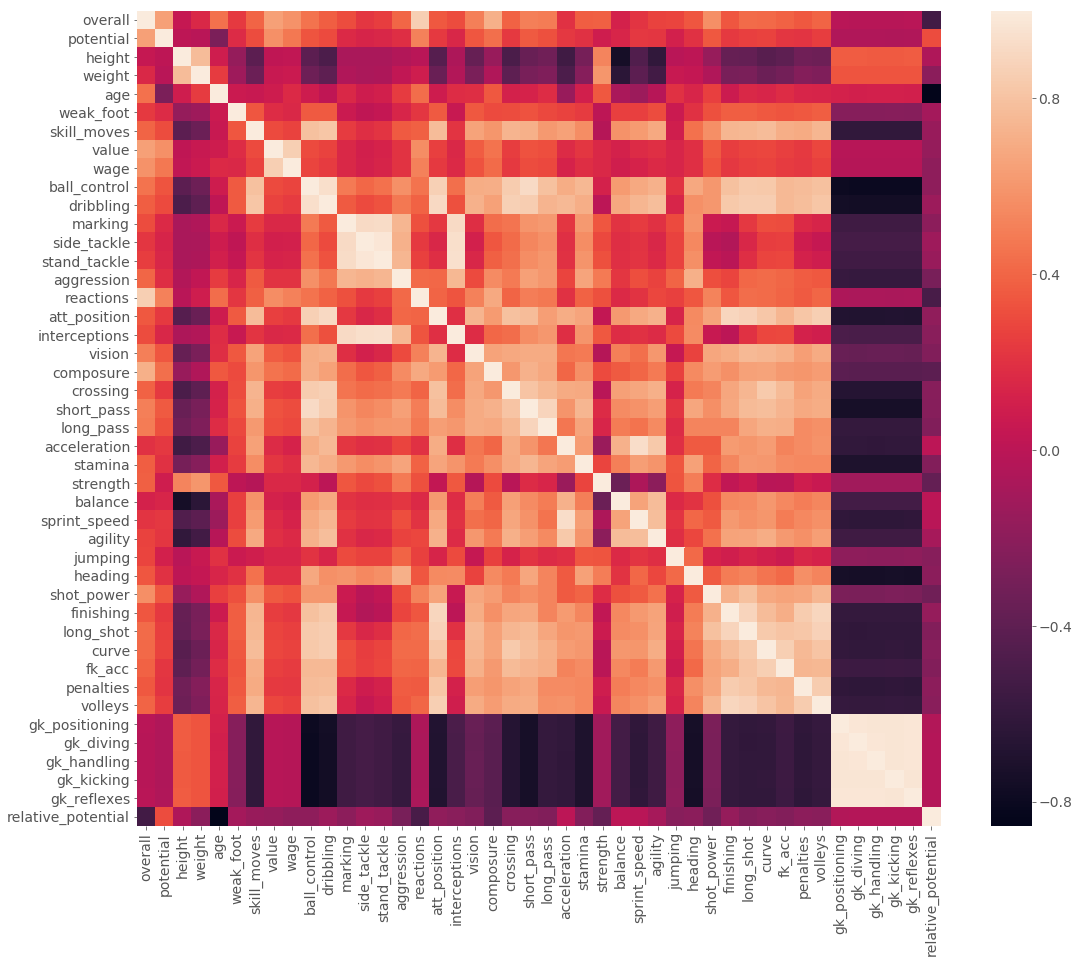

In [20]:
fig,ax = plt.subplots(1,1,figsize=(18,15))
sns.heatmap(players_df.corr(),ax=ax)
plt.show()

Ok, this heatmap has a lot of interesting information. Some of them are pretty obvious, like:

- The goalkeeping attributes are highly positively correlated with each other and negatively correlated with all other attributes. Goalkeepers are not good as outfield players.
- Value and wage are very correlated
- We can also see blocks of correlated features, which we can understand as defensive features (side_tackle, stand_tackle, ...), creative (short_pass, long_pass, ...), attacking etc. 

However, there are other not so obvious correlations. For example, some smaller blocks can be seen as being part of bigger blocks. On the bottom right, we see the attacking block (finishing, long_shot, ...), but if we zoom out, we see that this block is also correlated with the creative block, which makes sense, since midfielders and attacking players have some attributes in common. If we also look the relative potential row, we can identify a very negative correlation with age, which means that older players are likely to not improve very much in the future.

# 2.08 - Wage statistics

Here we explore relations concerning the wage of players. Let's start by looking the relation between value and wage on a scatter plot.

## 2.08.1 - Wage vs value

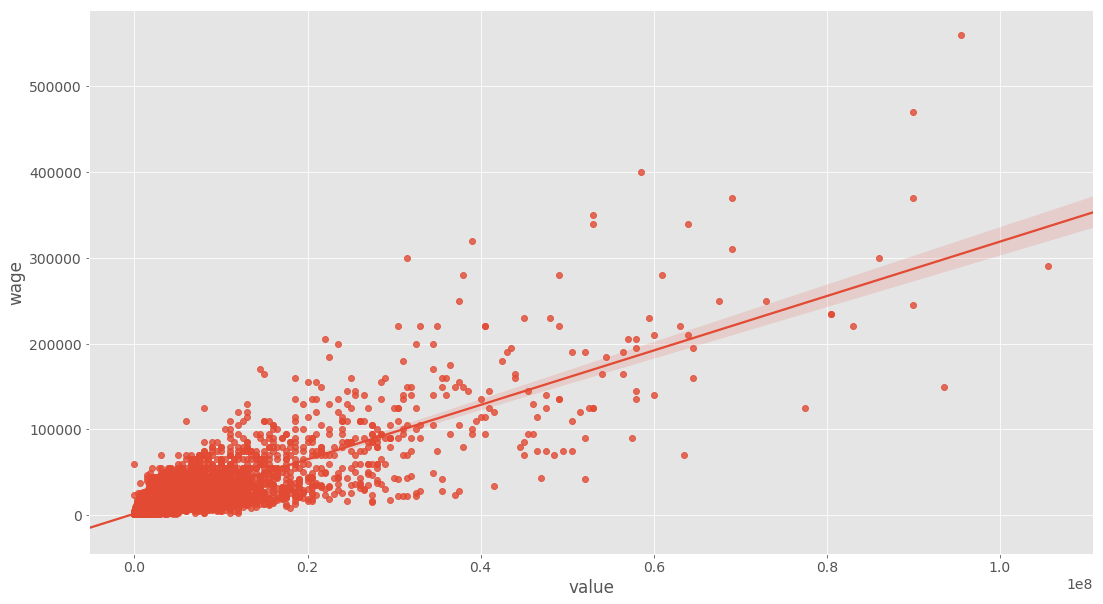

In [47]:
fig,ax = plt.subplots(1,1,figsize=(18,10))
sns.regplot(x="value", y="wage", data=players_df,ax=ax)

plt.show()

As expected, the correlation is linear. However, we can observe high heteroscedasticity, i.e., the variance changes a lot depending on the region of the plot.

## 2.08.2 - Wage vs Position

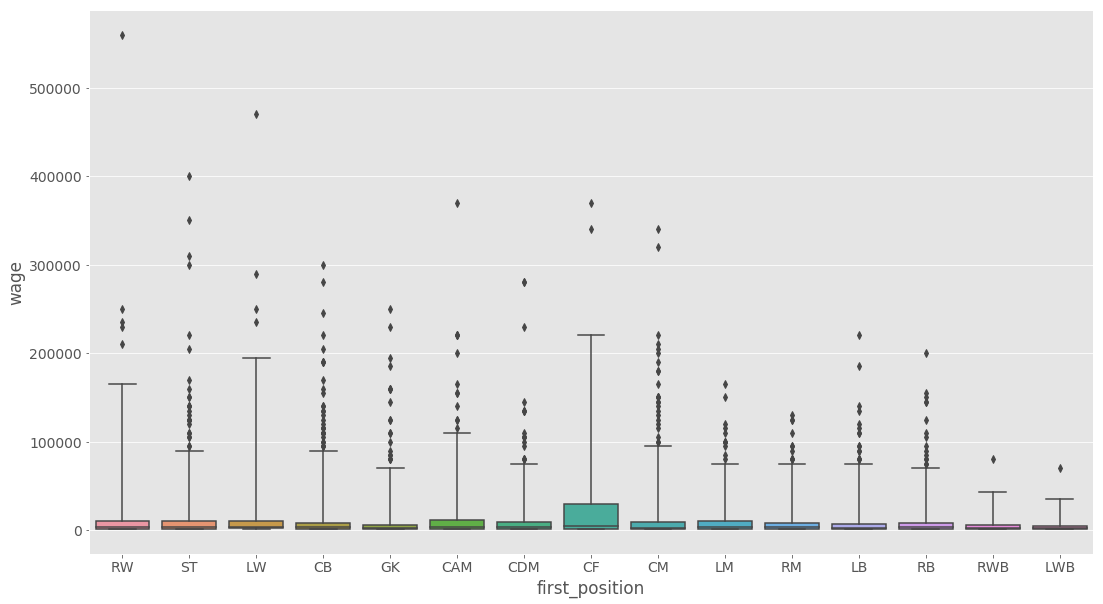

In [32]:
fig,ax = plt.subplots(1,1,figsize=(18,10))
sns.boxplot(x="first_position", y="wage", data=players_df,whis=[1, 99],ax=ax)

plt.show()

Since the wages are highly skewed, it is interesting to do a log transformation for the analysis.

In [45]:
players_df['log_wage'] = np.log1p(players_df['wage'])

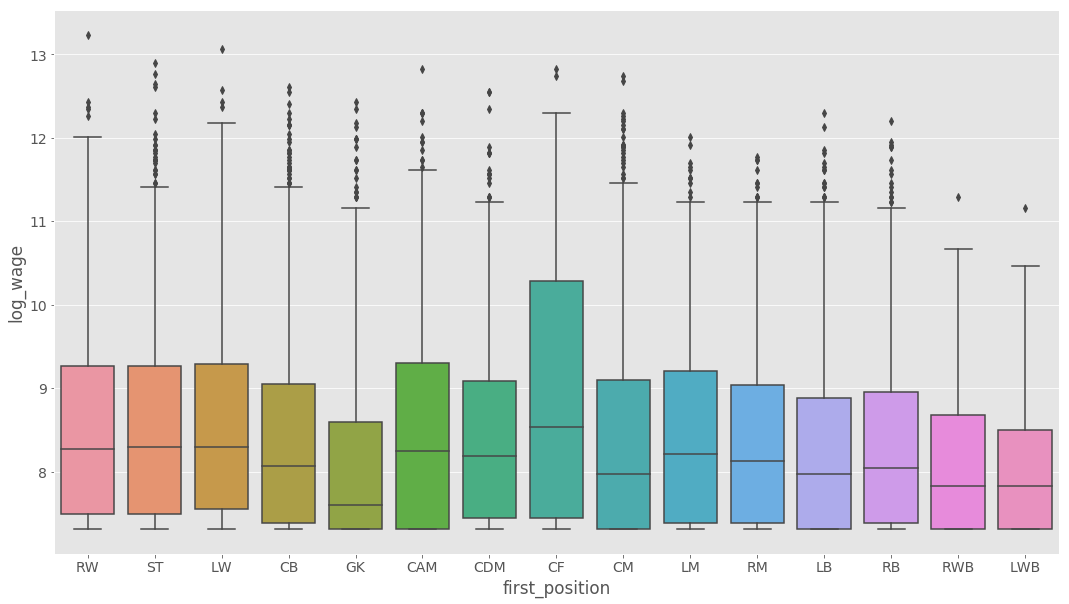

In [46]:
fig,ax = plt.subplots(1,1,figsize=(18,10))
sns.boxplot(x="first_position", y="log_wage", data=players_df,whis=[1, 99],ax=ax)

plt.show()

In general, there is no difference in wage depending on your main position of play. The only clear difference that I identify is on goalkeepers. They seem to receive less on average than other players. But the top players (the outliers in the plot) are paid as well as top players from other positions, so, I don't think there is a clear disadvantage of being a goalkeeper.

## 2.08.3 - Distribution of wages

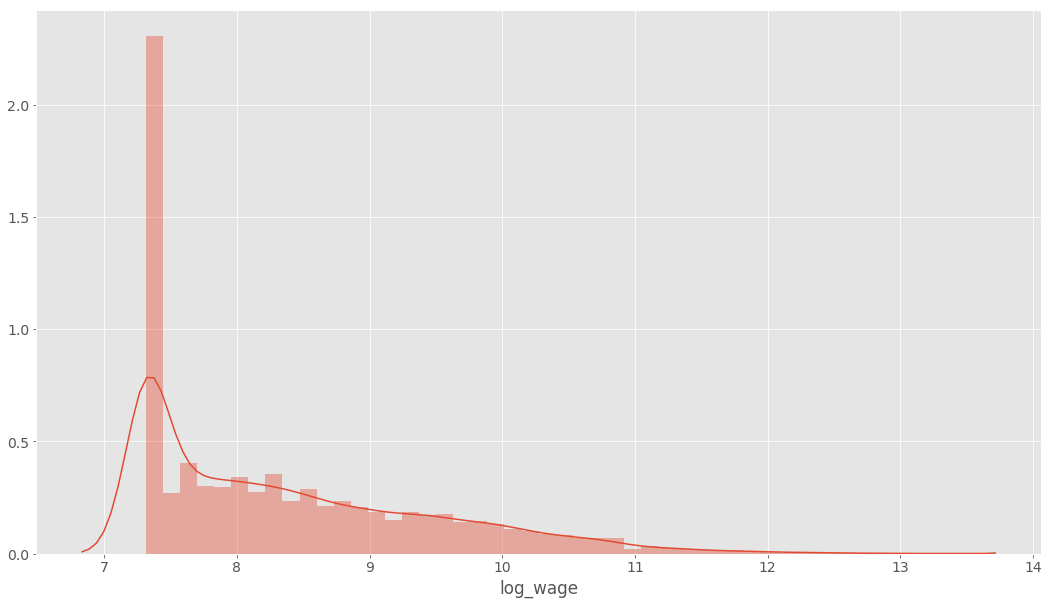

In [48]:
fig,ax = plt.subplots(1,1,figsize=(18,10))
sns.distplot(players_df['log_wage'].dropna(),ax=ax)

plt.show()

Even after a log transformation, the data is highly right skewed. This may pose a problem in a machine learning model to predict wages. But this a a matter for another notebook.

## 2.08.4 Wage vs Overall

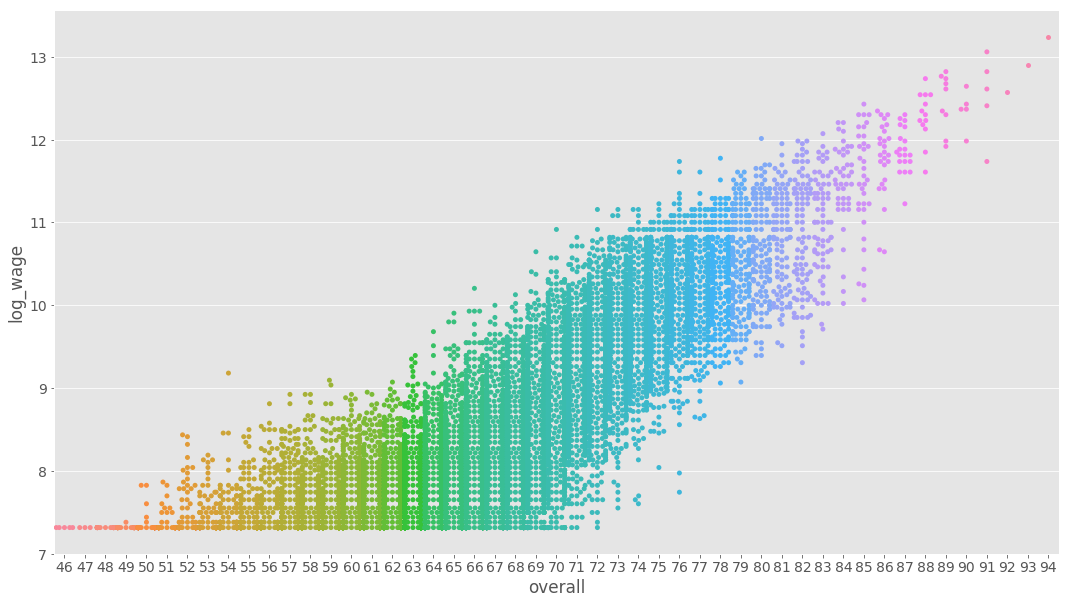

In [49]:
fig,ax = plt.subplots(1,1,figsize=(18,10))
sns.swarmplot(x="overall", y="log_wage", data=players_df,ax=ax)

plt.show()

# 2.09 - Best and worst attributes for each position

## 2.09.1 - Average of all players

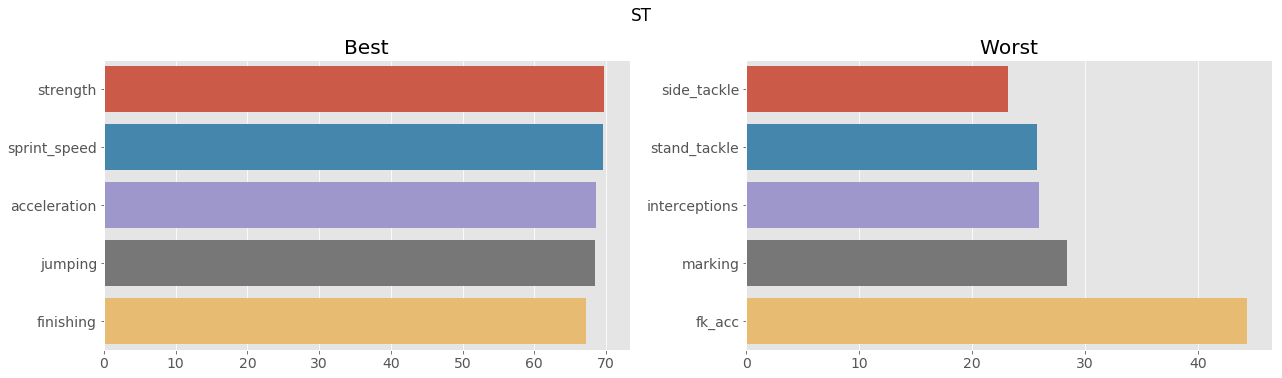

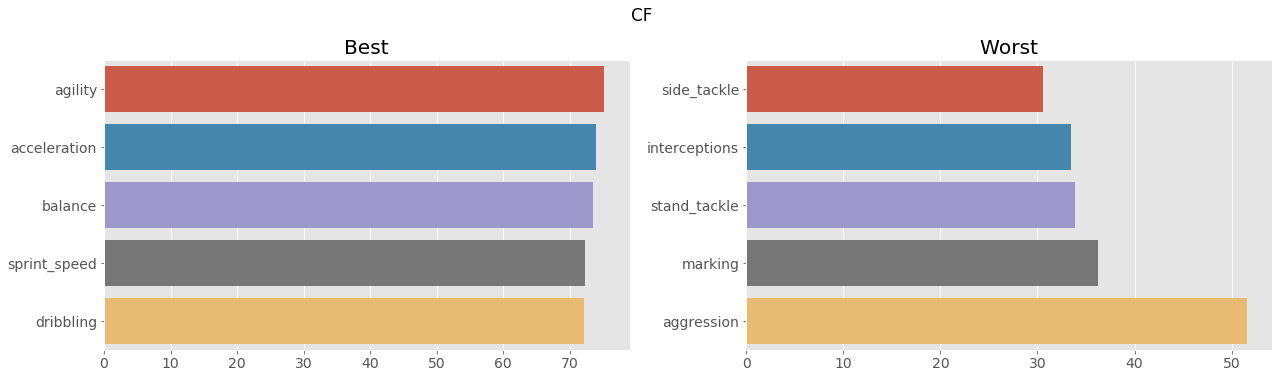

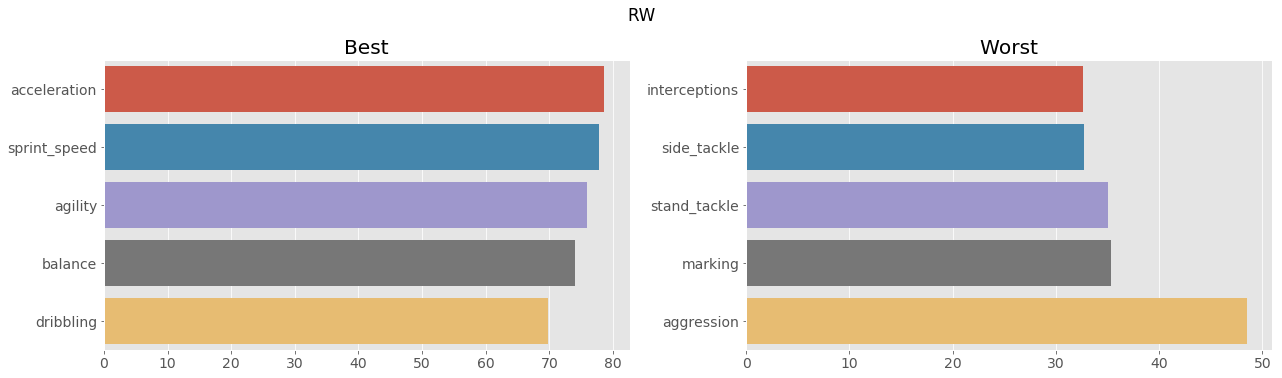

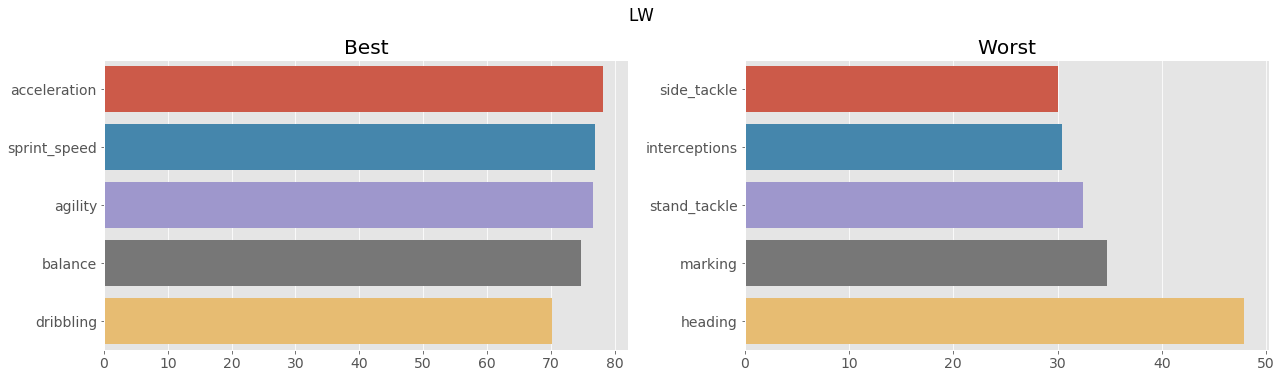

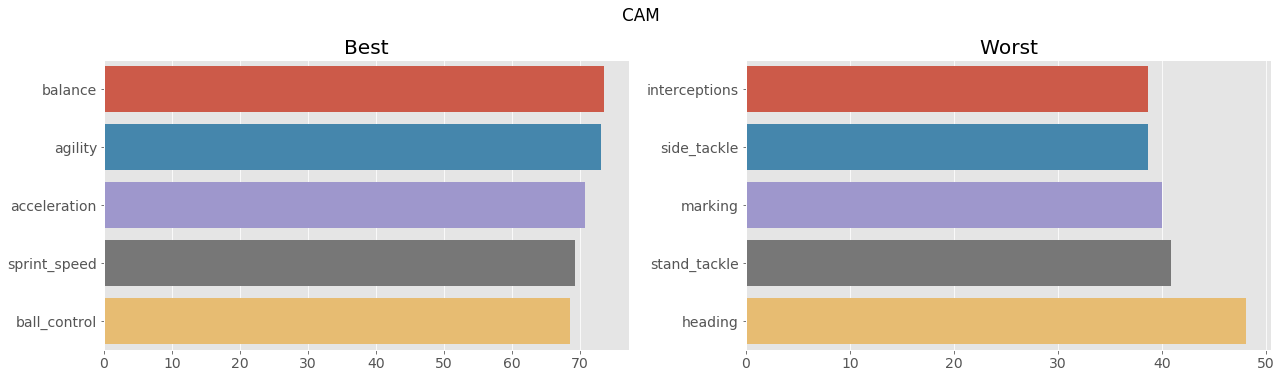

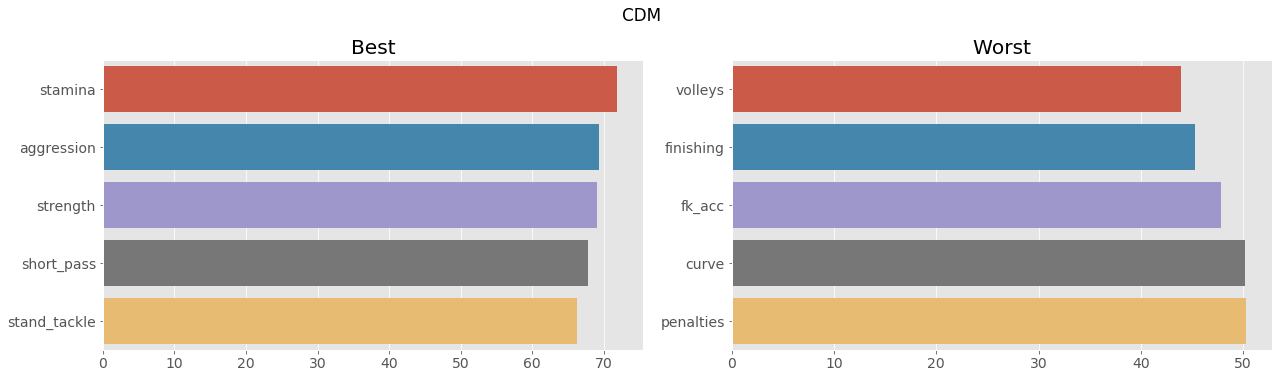

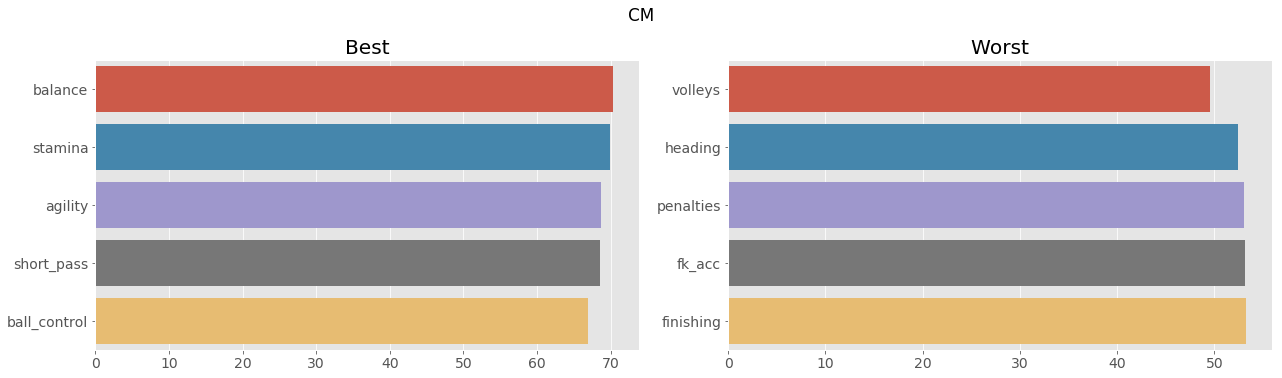

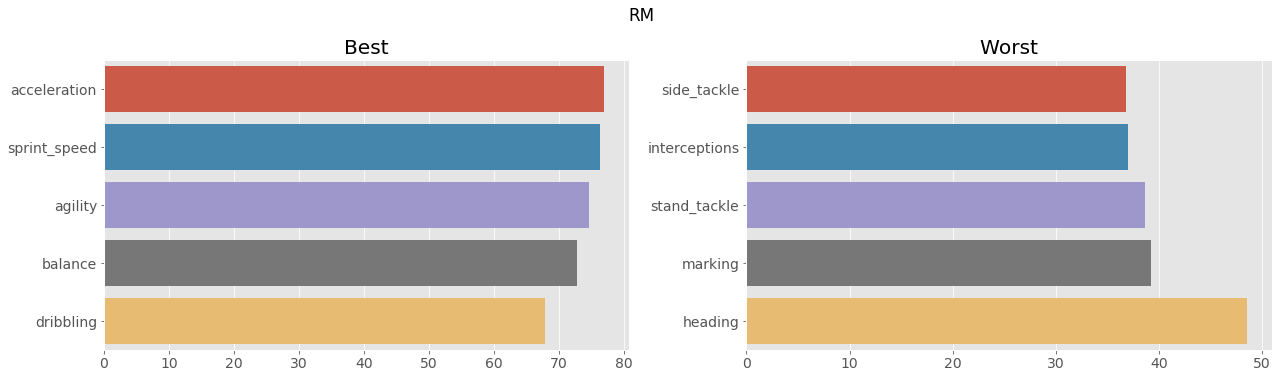

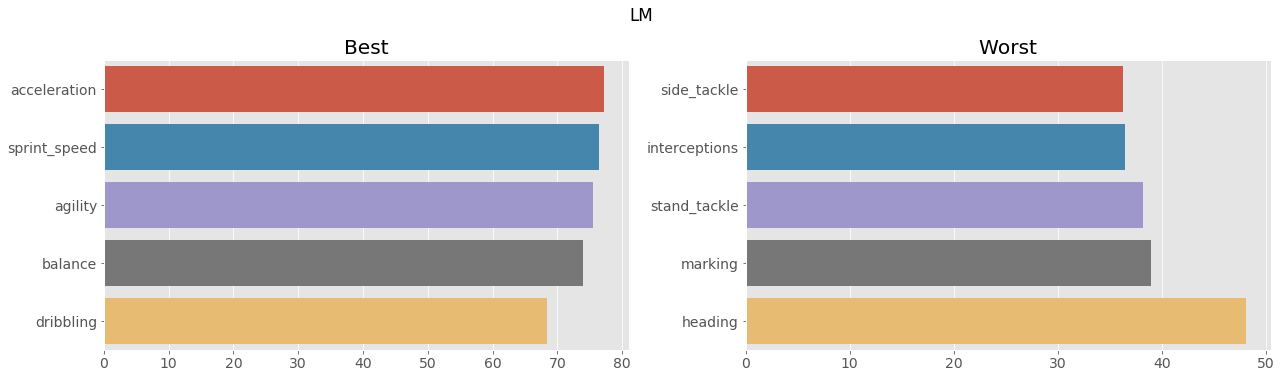

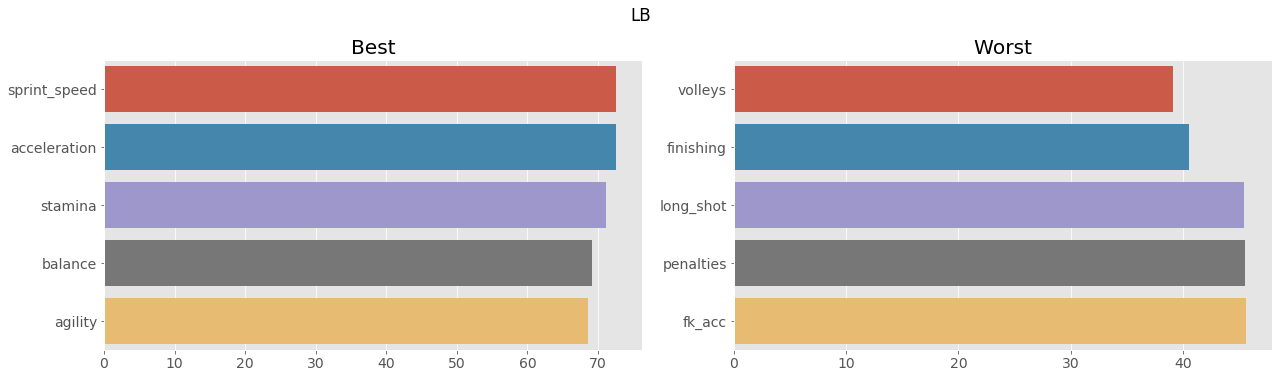

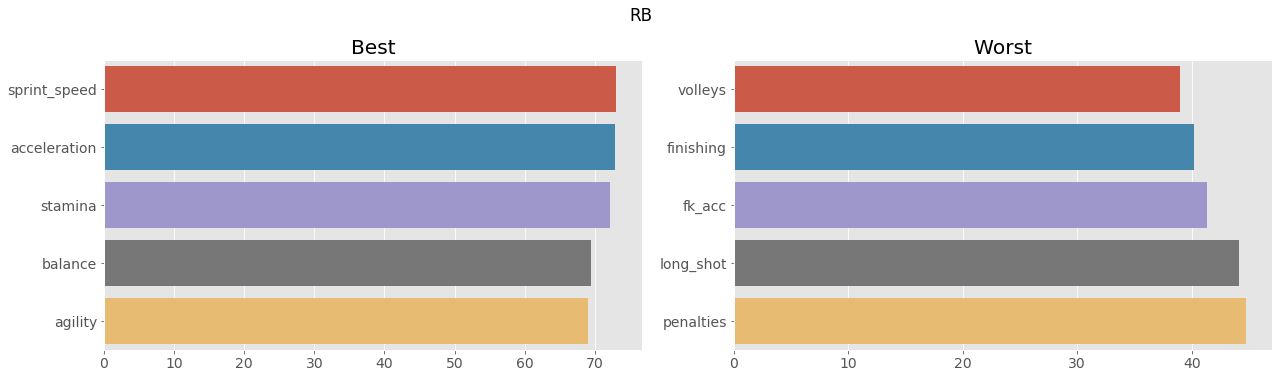

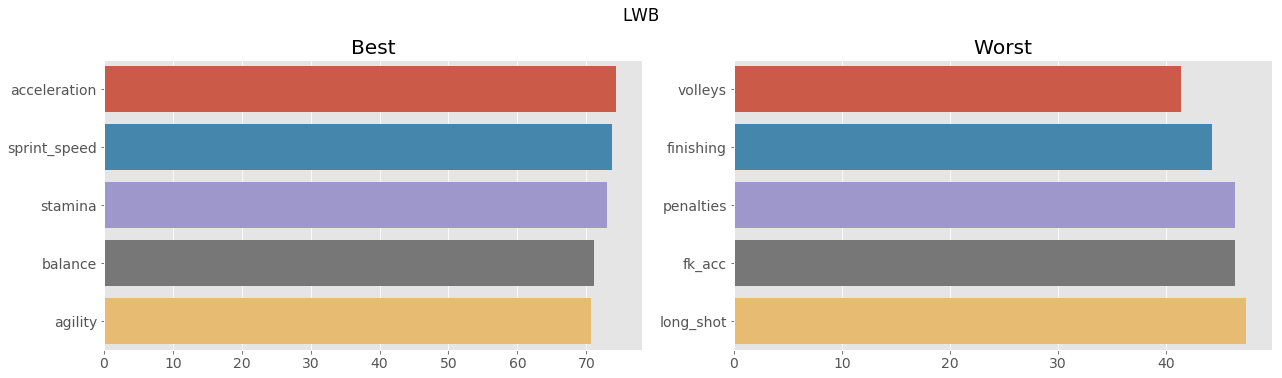

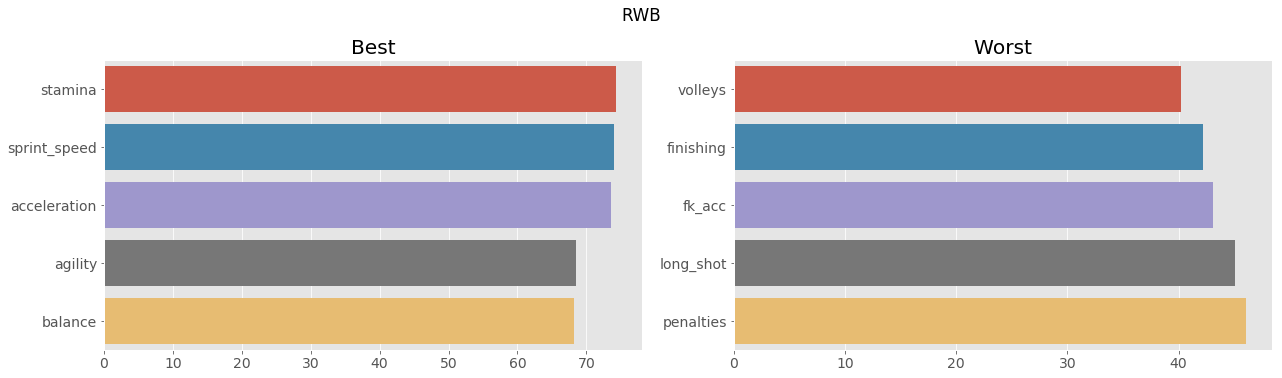

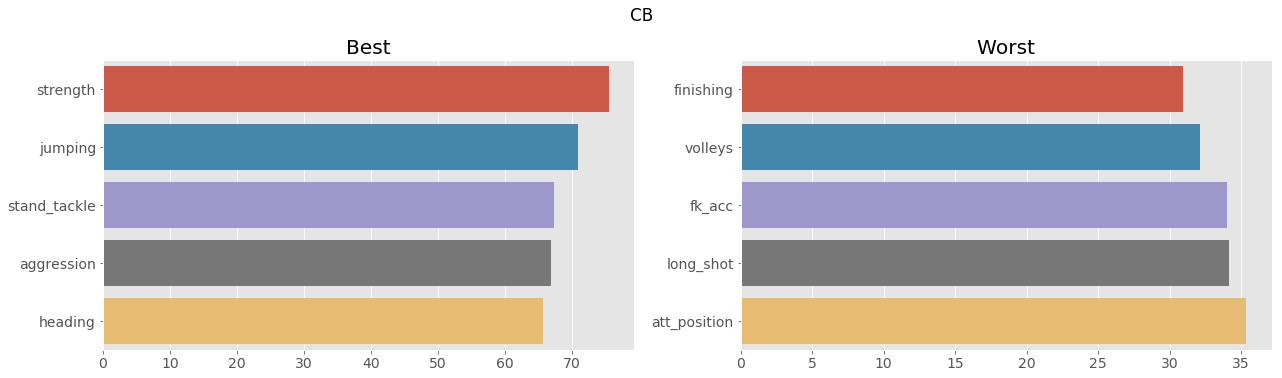

In [83]:
attributes = players_df.columns.tolist()[18:-9]
position_attributes = players_df.groupby('first_position')[attributes].mean().transpose()

def best_and_worst_attributes(position):
    fig,ax = plt.subplots(1,2,figsize=(18,5))

    df_position = position_attributes[position].sort_values(ascending=False)
    sns.barplot(x = df_position[:5].values,y=df_position[:5].index,ax=ax[0])

    df_position = df_position.sort_values()
    sns.barplot(x = df_position[:5].values,y=df_position[:5].index,ax=ax[1])

    ax[0].set_title('Best')
    ax[1].set_title('Worst')
    fig.suptitle(position,y=1.05)
    fig.tight_layout(pad=1)
    plt.show()

positions = ['ST','CF','RW','LW','CAM','CDM','CM','RM','LM','LB','RB','LWB','RWB','CB']
for position in positions:
    best_and_worst_attributes(position)

## 2.09.2 - Average of good players (overall rating >= 75)

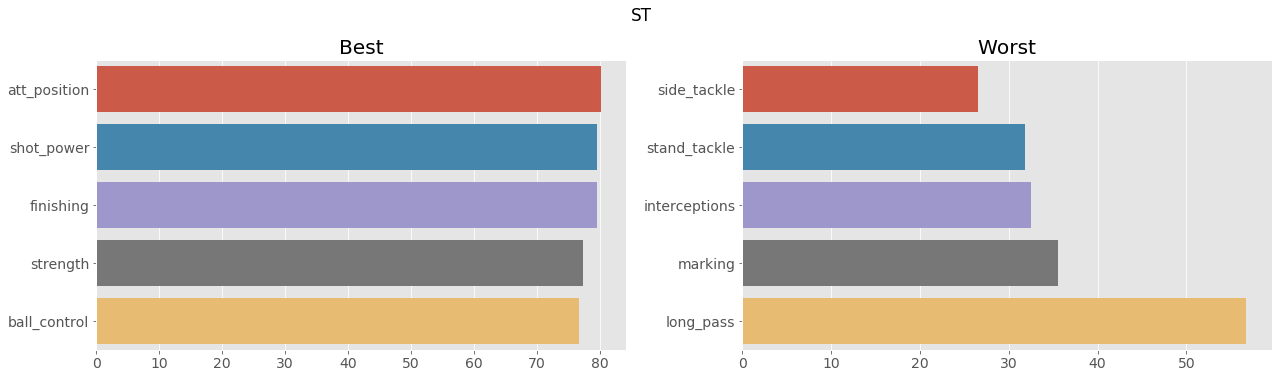

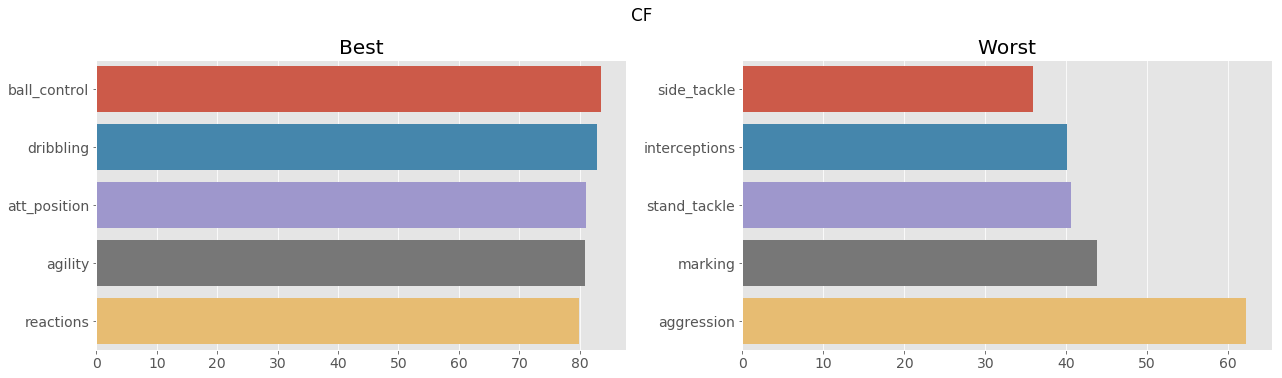

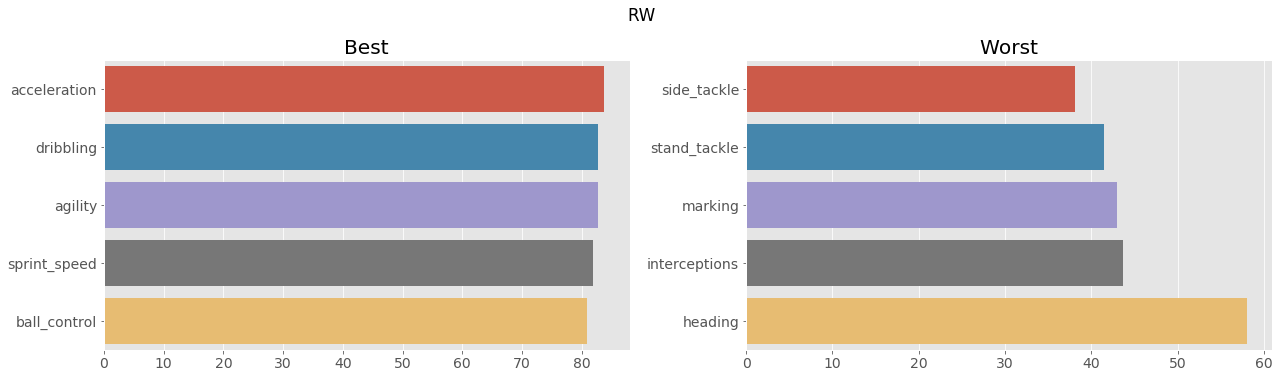

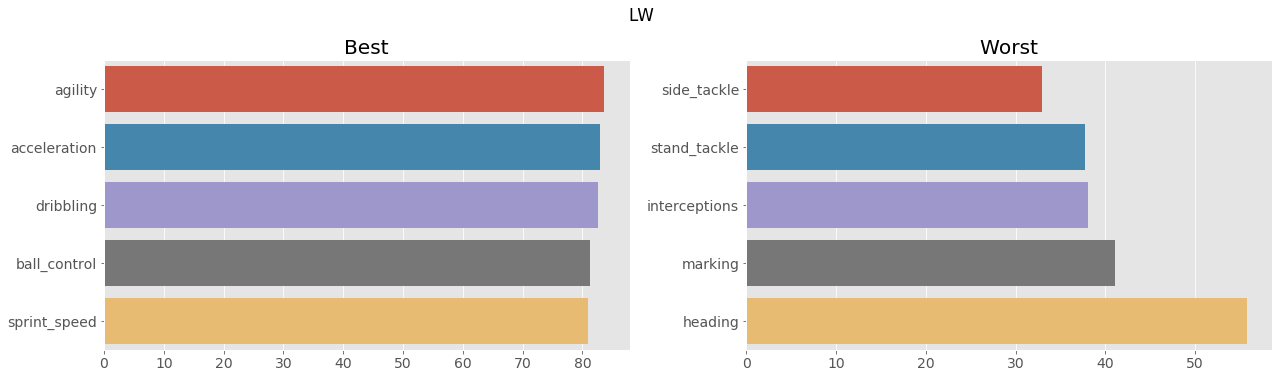

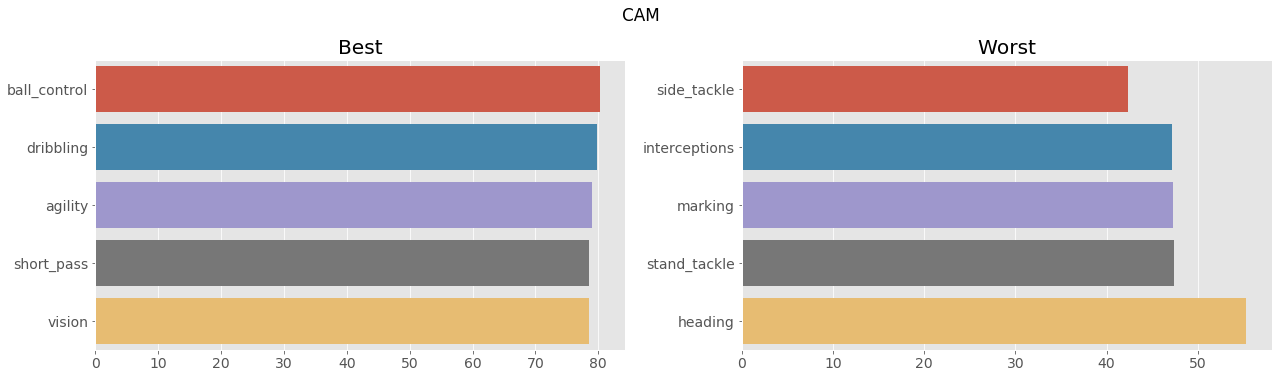

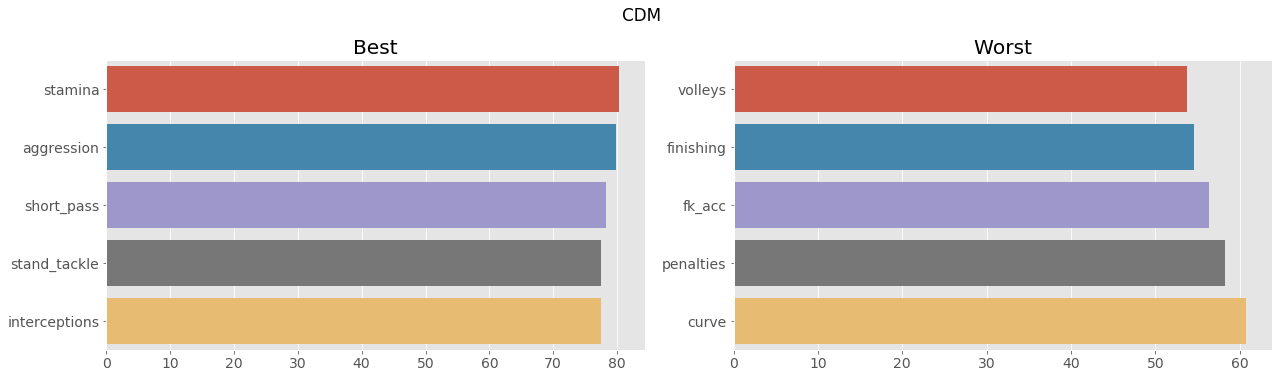

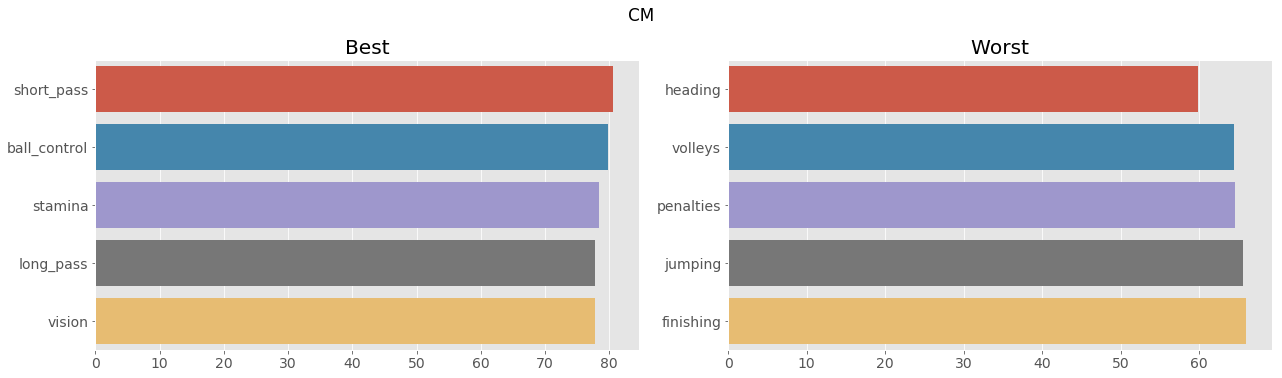

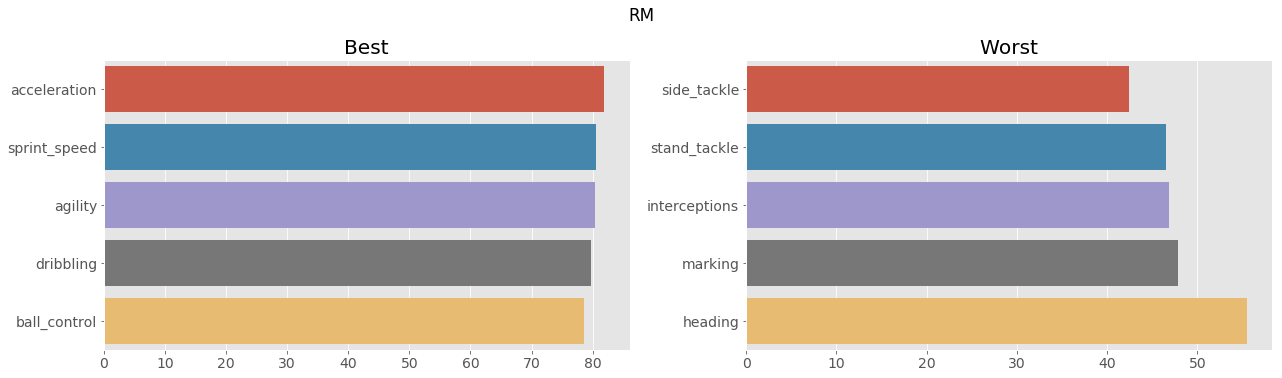

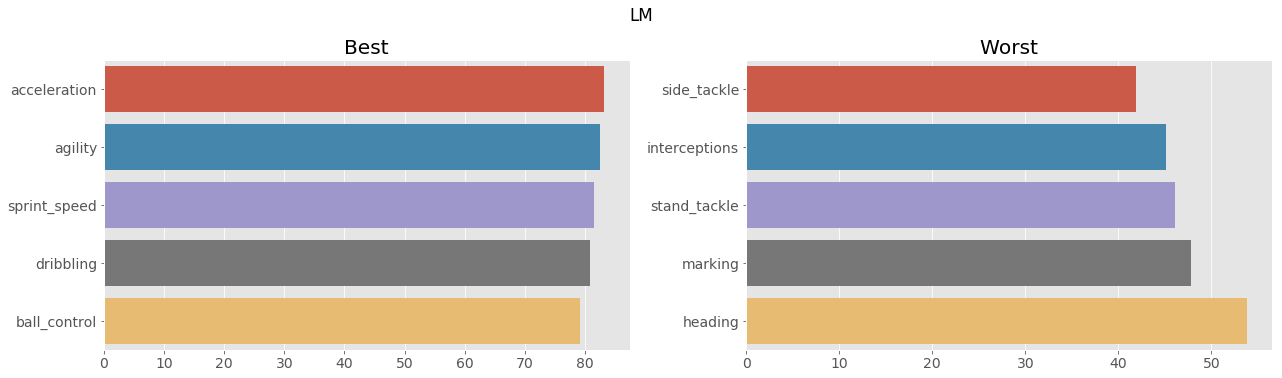

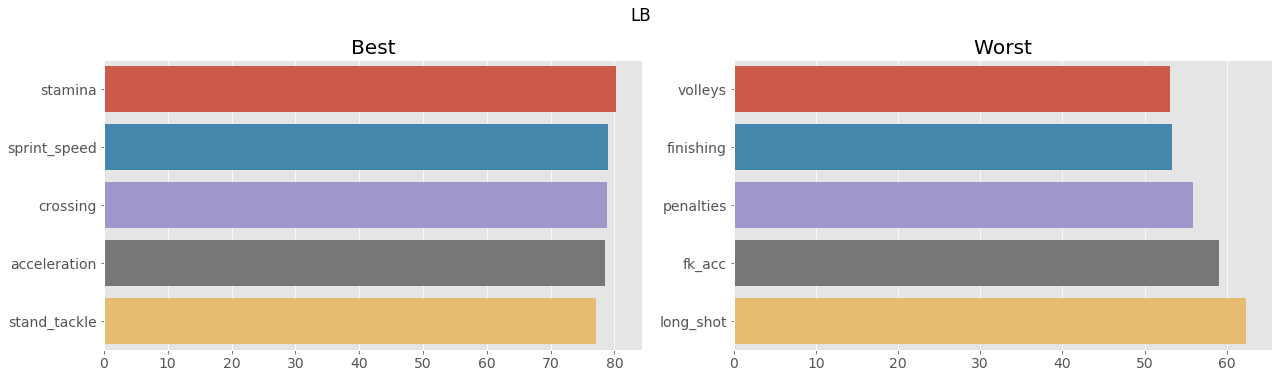

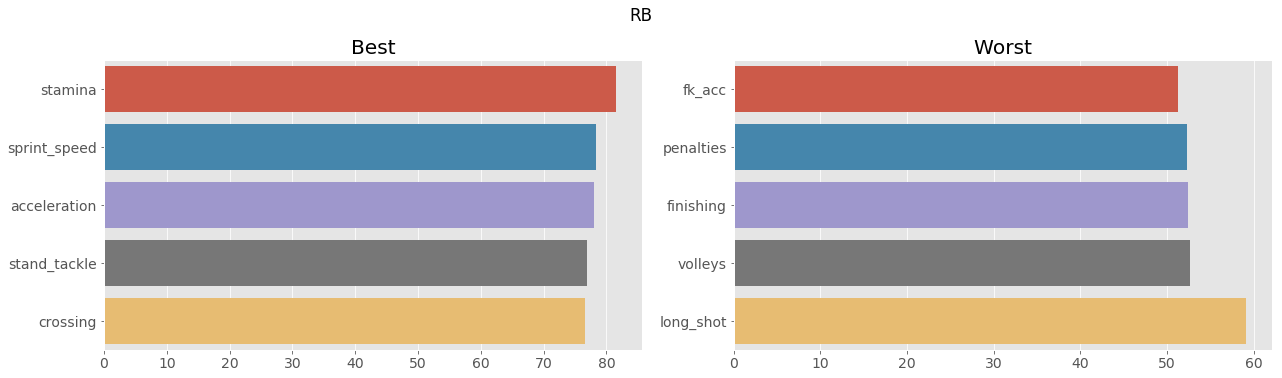

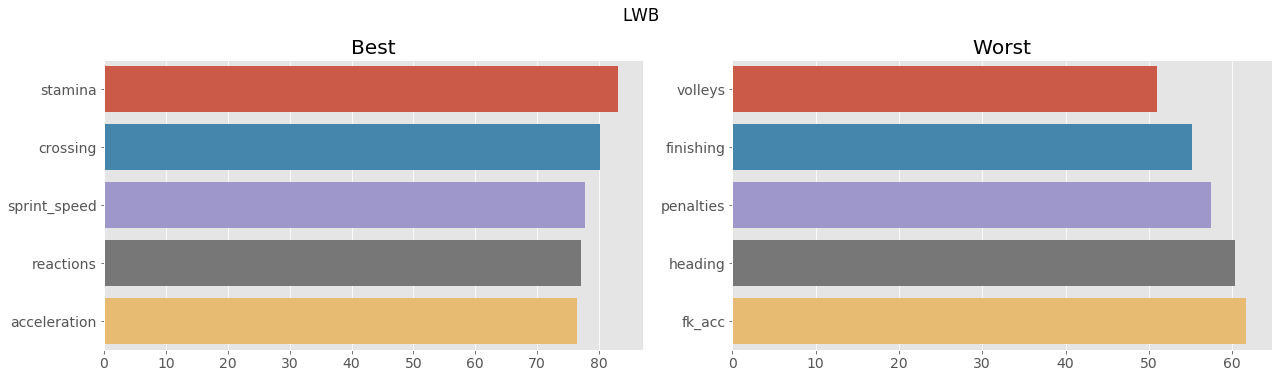

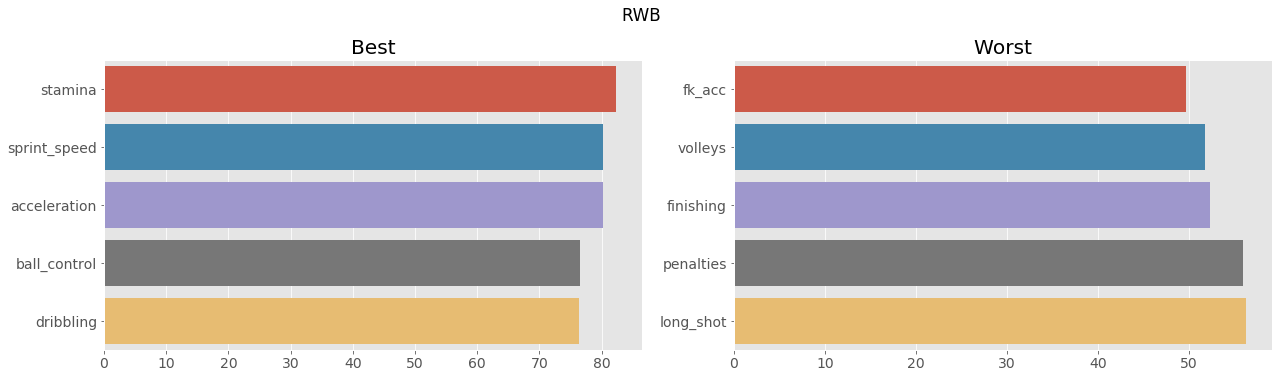

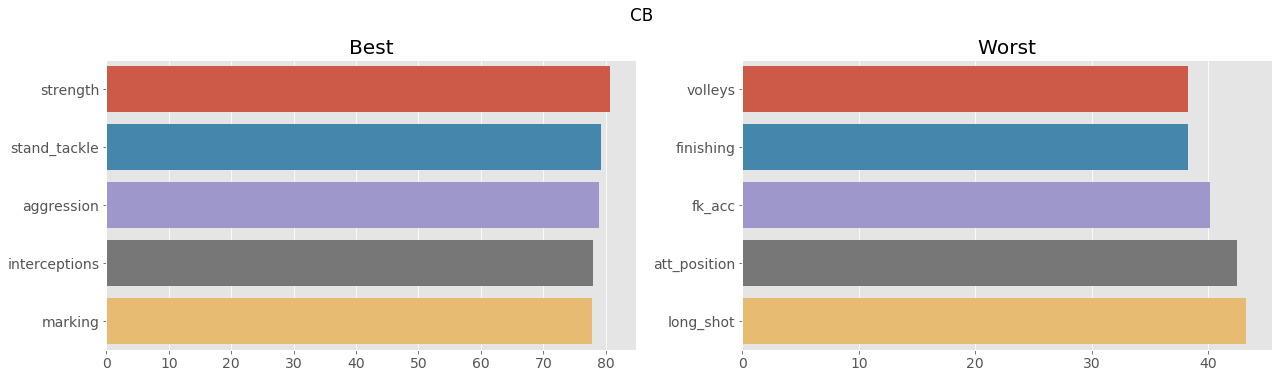

In [85]:
position_attributes = players_df[players_df['overall'] >=75].groupby('first_position')[attributes].mean().transpose()
for position in positions:
    best_and_worst_attributes(position)

To me, the most interesting aspect of these plots is that they make transparent the differences of skills required in similar positions (like ST and CF, or CDM, CM, and CAM). For example, STs are required to be on the right place to score (high att. position), while CFs need to be able to hold the ball and get rid of the defenders (high ball control and dribbling skills).

Also, it is clear that the average top skills of good players differ a lot from the top skills of other players (see for instance, the avg top skills of all STs and the avg of only good STs). This makes us think that good players know what they are supposed to be doing in the field much better than less skilled players. It goes beyond hard skills like the ability of shooting and passing the ball. **Random nice comment**: this also applies to data science and any other job. It does not suffice to be able to do something, you need to know how to use your skills to do what you are supposed to do!

# 2.10 - Number of players by position

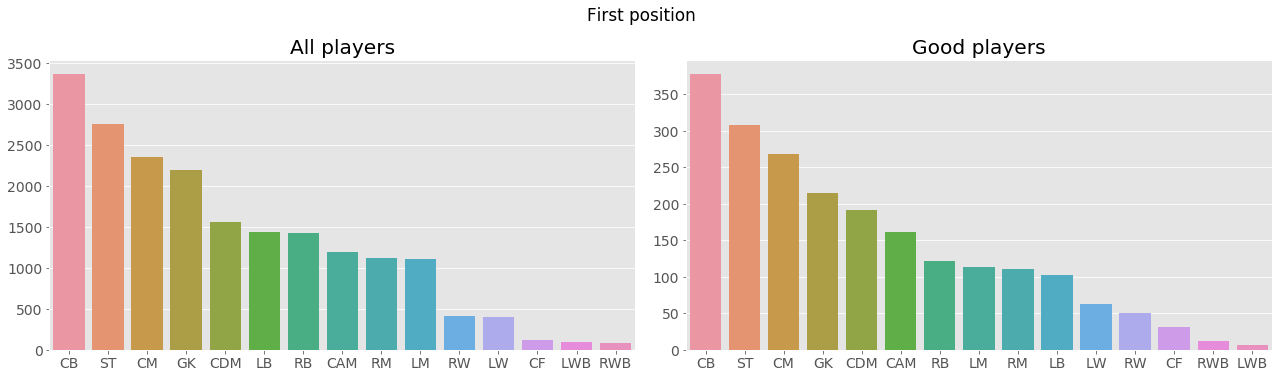

In [95]:
fig,ax = plt.subplots(1,2,figsize=(18,5))

df_position = players_df['first_position'].value_counts()
sns.barplot(x = df_position.index, y = df_position.values,ax=ax[0])

good_players_df = players_df[players_df['overall'] >=75]
df_position = good_players_df['first_position'].value_counts()
sns.barplot(x = df_position.index, y = df_position.values,ax=ax[1])

ax[0].set_title('All players')
ax[1].set_title('Good players')
fig.suptitle('First position',y=1.05)
fig.tight_layout(pad=1)
plt.show()

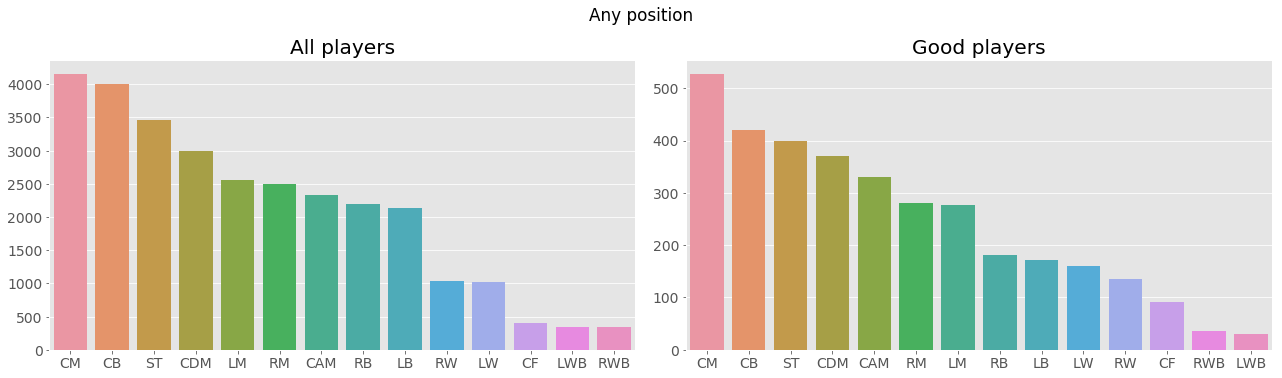

In [97]:
fig,ax = plt.subplots(1,2,figsize=(18,5))

players_by_position = {}
for position in positions:
    count = players_df[players_df['preferred_positions'].str.contains(position)].shape[0]
    players_by_position[position] = count
    
players_by_position['RW'] = players_by_position['RW'] - players_by_position['RWB']
players_by_position['LW'] = players_by_position['LW'] - players_by_position['LWB']
df_position = pd.Series(players_by_position).sort_values(ascending=False)
sns.barplot(x = df_position.index, y = df_position.values,ax=ax[0])

players_by_position = {}
for position in positions:
    count = good_players_df[good_players_df['preferred_positions'].str.contains(position)].shape[0]
    players_by_position[position] = count
    
players_by_position['RW'] = players_by_position['RW'] - players_by_position['RWB']
players_by_position['LW'] = players_by_position['LW'] - players_by_position['LWB']
df_position = pd.Series(players_by_position).sort_values(ascending=False)
sns.barplot(x = df_position.index, y = df_position.values,ax=ax[1])

ax[0].set_title('All players')
ax[1].set_title('Good players')
fig.suptitle('Any position',y=1.05)
fig.tight_layout(pad=1)
plt.show()

# 2.11 - Right-footed vs Left-footed players

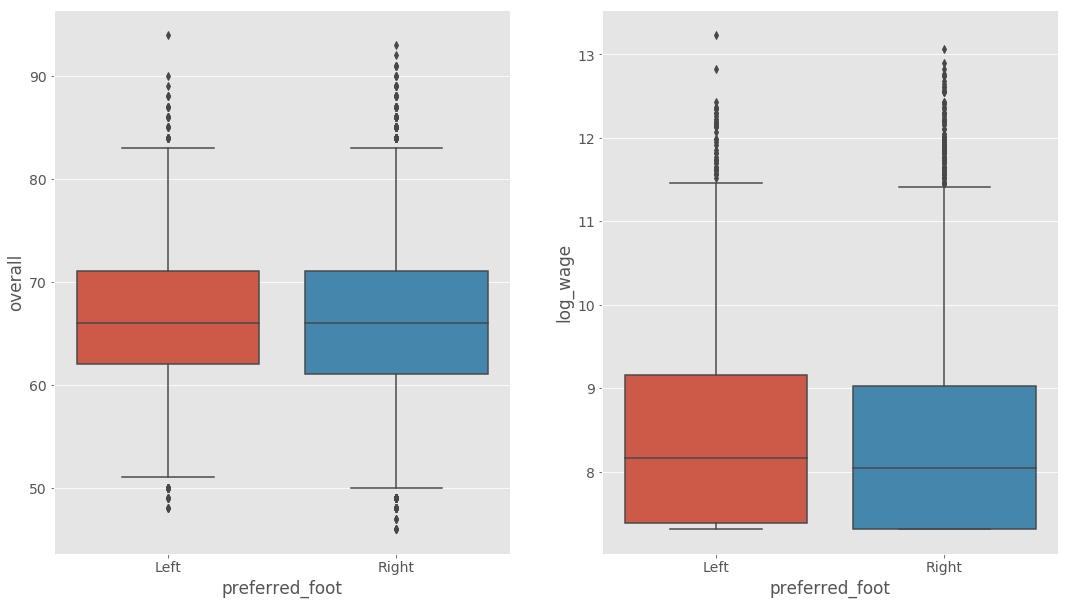

In [121]:
fig,ax = plt.subplots(1,2,figsize=(18,10))
sns.boxplot(x="preferred_foot", y="overall", data=players_df,whis=[1, 99],ax=ax[0])
sns.boxplot(x="preferred_foot", y="log_wage", data=players_df,whis=[1, 99],ax=ax[1])

plt.show()

Despite what many people believe, it does not seem that left-footed players are better than right-footed players. The stats about them are the same as of right-footed players and they are not privileged (by wage) on the market. Actually, this never made any sense to me, and here I just wanted to see if my intuition was right.

# 2.12 - Height, Weight, and BMI of players

## 2.12.1 - Height vs position

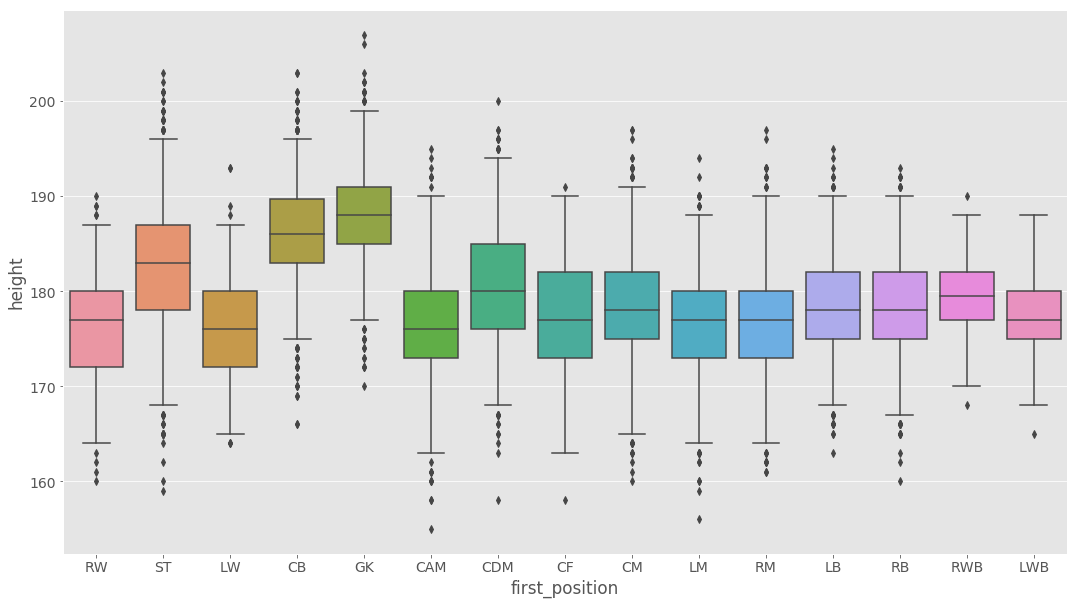

In [100]:
fig,ax = plt.subplots(1,1,figsize=(18,10))
sns.boxplot(x="first_position", y="height", data=players_df,whis=[1, 99],ax=ax)

plt.show()

Of course goalkeepers are the tallest players on average (there are curious outliers with ~1,70m). Almost all other positions have no substantial difference in height, but strikers and centre-backs are clearly taller than other players. The reason must be the need of clubs for players that are able to score by heading (The taller strikers) and to prevent other of scoring by heading (the taller centre-backs).

## 2.12.2 - The tallest (relevant) players

In [114]:
good_players_df[good_players_df['first_position'] != 'GK'][['name','height','team_club','preferred_positions','overall']].sort_values('height',ascending=False)[:10]

,name,height,team_club,preferred_positions,overall
1161,Jannik Vestergaard,199,Southampton,CB,77
1382,Philip Billing,197,AFC Bournemouth,CM,76
1086,Ludovic Ajorque,197,RC Strasbourg Alsace,ST,77
333,Wout Weghorst,197,VfL Wolfsburg,ST,81
1455,Solomon Kverkvelia,196,Lokomotiv Moscow,CB,76
701,Steven Nzonzi,196,Stade Rennais FC,CDM/CM,79
493,Salif Sané,196,FC Schalke 04,CB/CDM,80
518,Artem Dzyuba,196,Free Agents,ST,80
517,Bas Dost,196,Eintracht Frankfurt,ST,80
373,Sebastián Coates,196,Sporting CP,CB,81


## 2.12.3 - Overall vs BMI

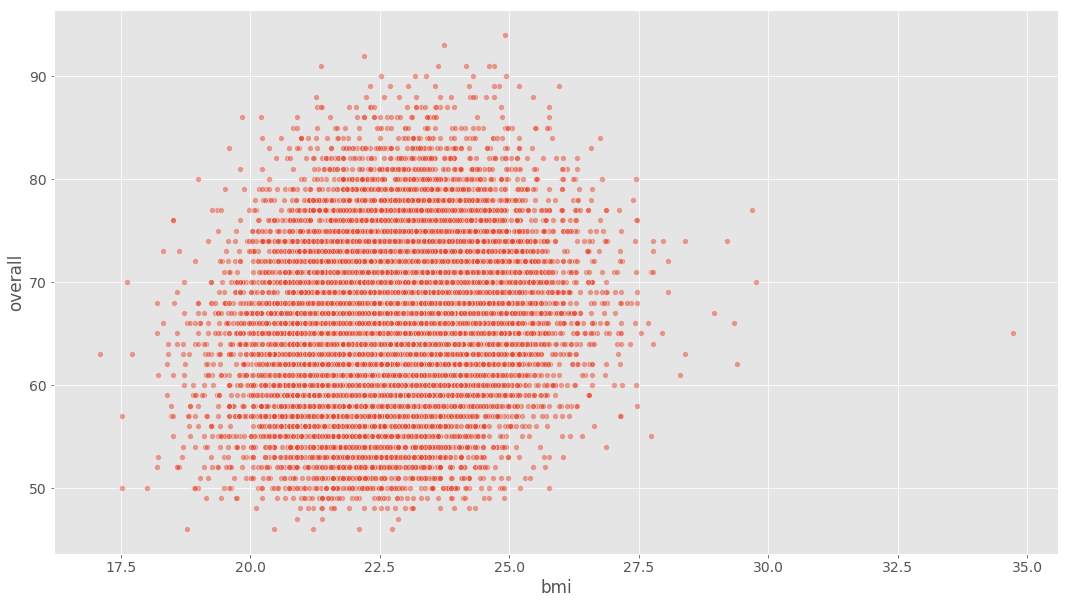

In [110]:
players_df['bmi'] = players_df['weight']/(players_df['height']/100)**2

fig,ax = plt.subplots(1,1,figsize=(18,10))
sns.scatterplot(x="bmi", y="overall", data=players_df,alpha=0.5,ax=ax)

plt.show()

In [116]:
# Finding the overweighted players
players_df[players_df['first_position'] != 'GK'][['name','age','bmi','team_club','preferred_positions','overall']].sort_values('bmi',ascending=False)[:10]

,name,age,bmi,team_club,preferred_positions,overall
11725,Adebayo Akinfenwa,38,34.717839,Wycombe Wanderers,ST,65
5292,Santiago Mosquera,25,29.761905,FC Dallas,LM/RM,70
1054,Ramón Ábila,30,29.684956,Boca Juniors,ST,77
14763,Junior Morias,25,29.402920,St. Mirren,ST,62
2723,Wes Morgan,36,29.194126,Leicester City,CB,74
8777,Gabadhino Mhango,27,28.959000,Orlando Pirates,ST,67
13939,Luis Martínez,33,28.400548,Tiburones Rojos de Veracruz,CM/CDM,63
2252,Hélton Celanova,28,28.395062,Internacional,ST,74
14937,Daryl Dike,20,28.293345,Orlando City Soccer Club,ST,61
3855,Harlem Gnohéré,32,28.068918,Fotbal Club FCSB,ST,72


WOW, there is a guy that has a body mass index of almost 35! [Adebayo Akinfenwa](https://en.wikipedia.org/wiki/Adebayo_Akinfenwa) plays in the english league one (third division of english football), and has 38 years old. He seems to be kind of a celebrity, so, check out his page on wikipedia.